In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import tensorflow as tf
from tensorflow.keras import layers, models

In [3]:
BASE_DIR = 'Datasets/'
WORKING_DIR = 'working'

In [4]:
# load vgg16 model
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [5]:
import concurrent.futures
from tqdm import tqdm

features = {}
directory = os.path.join(BASE_DIR, 'Images')

def process_image(img_name):
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    return image_id, feature

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_image, os.listdir(directory)), total=len(os.listdir(directory))))

for image_id, feature in results:
    features[image_id] = feature


  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1732180496.062873      70 service.cc:145] XLA service 0x78b678098790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732180496.062945      70 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732180496.062951      70 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732180499.988364      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [05:12<00:00, 25.92it/s]


In [6]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [7]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [8]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:
# create mapping of image to captions
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 703111.71it/s]


In [10]:
len(mapping)

8091

In [11]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower() 
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [12]:
# before
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
clean(mapping)

In [14]:
# after
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
len(all_captions)

40455

In [17]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [19]:
vocab_size

8485

In [20]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [21]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [22]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

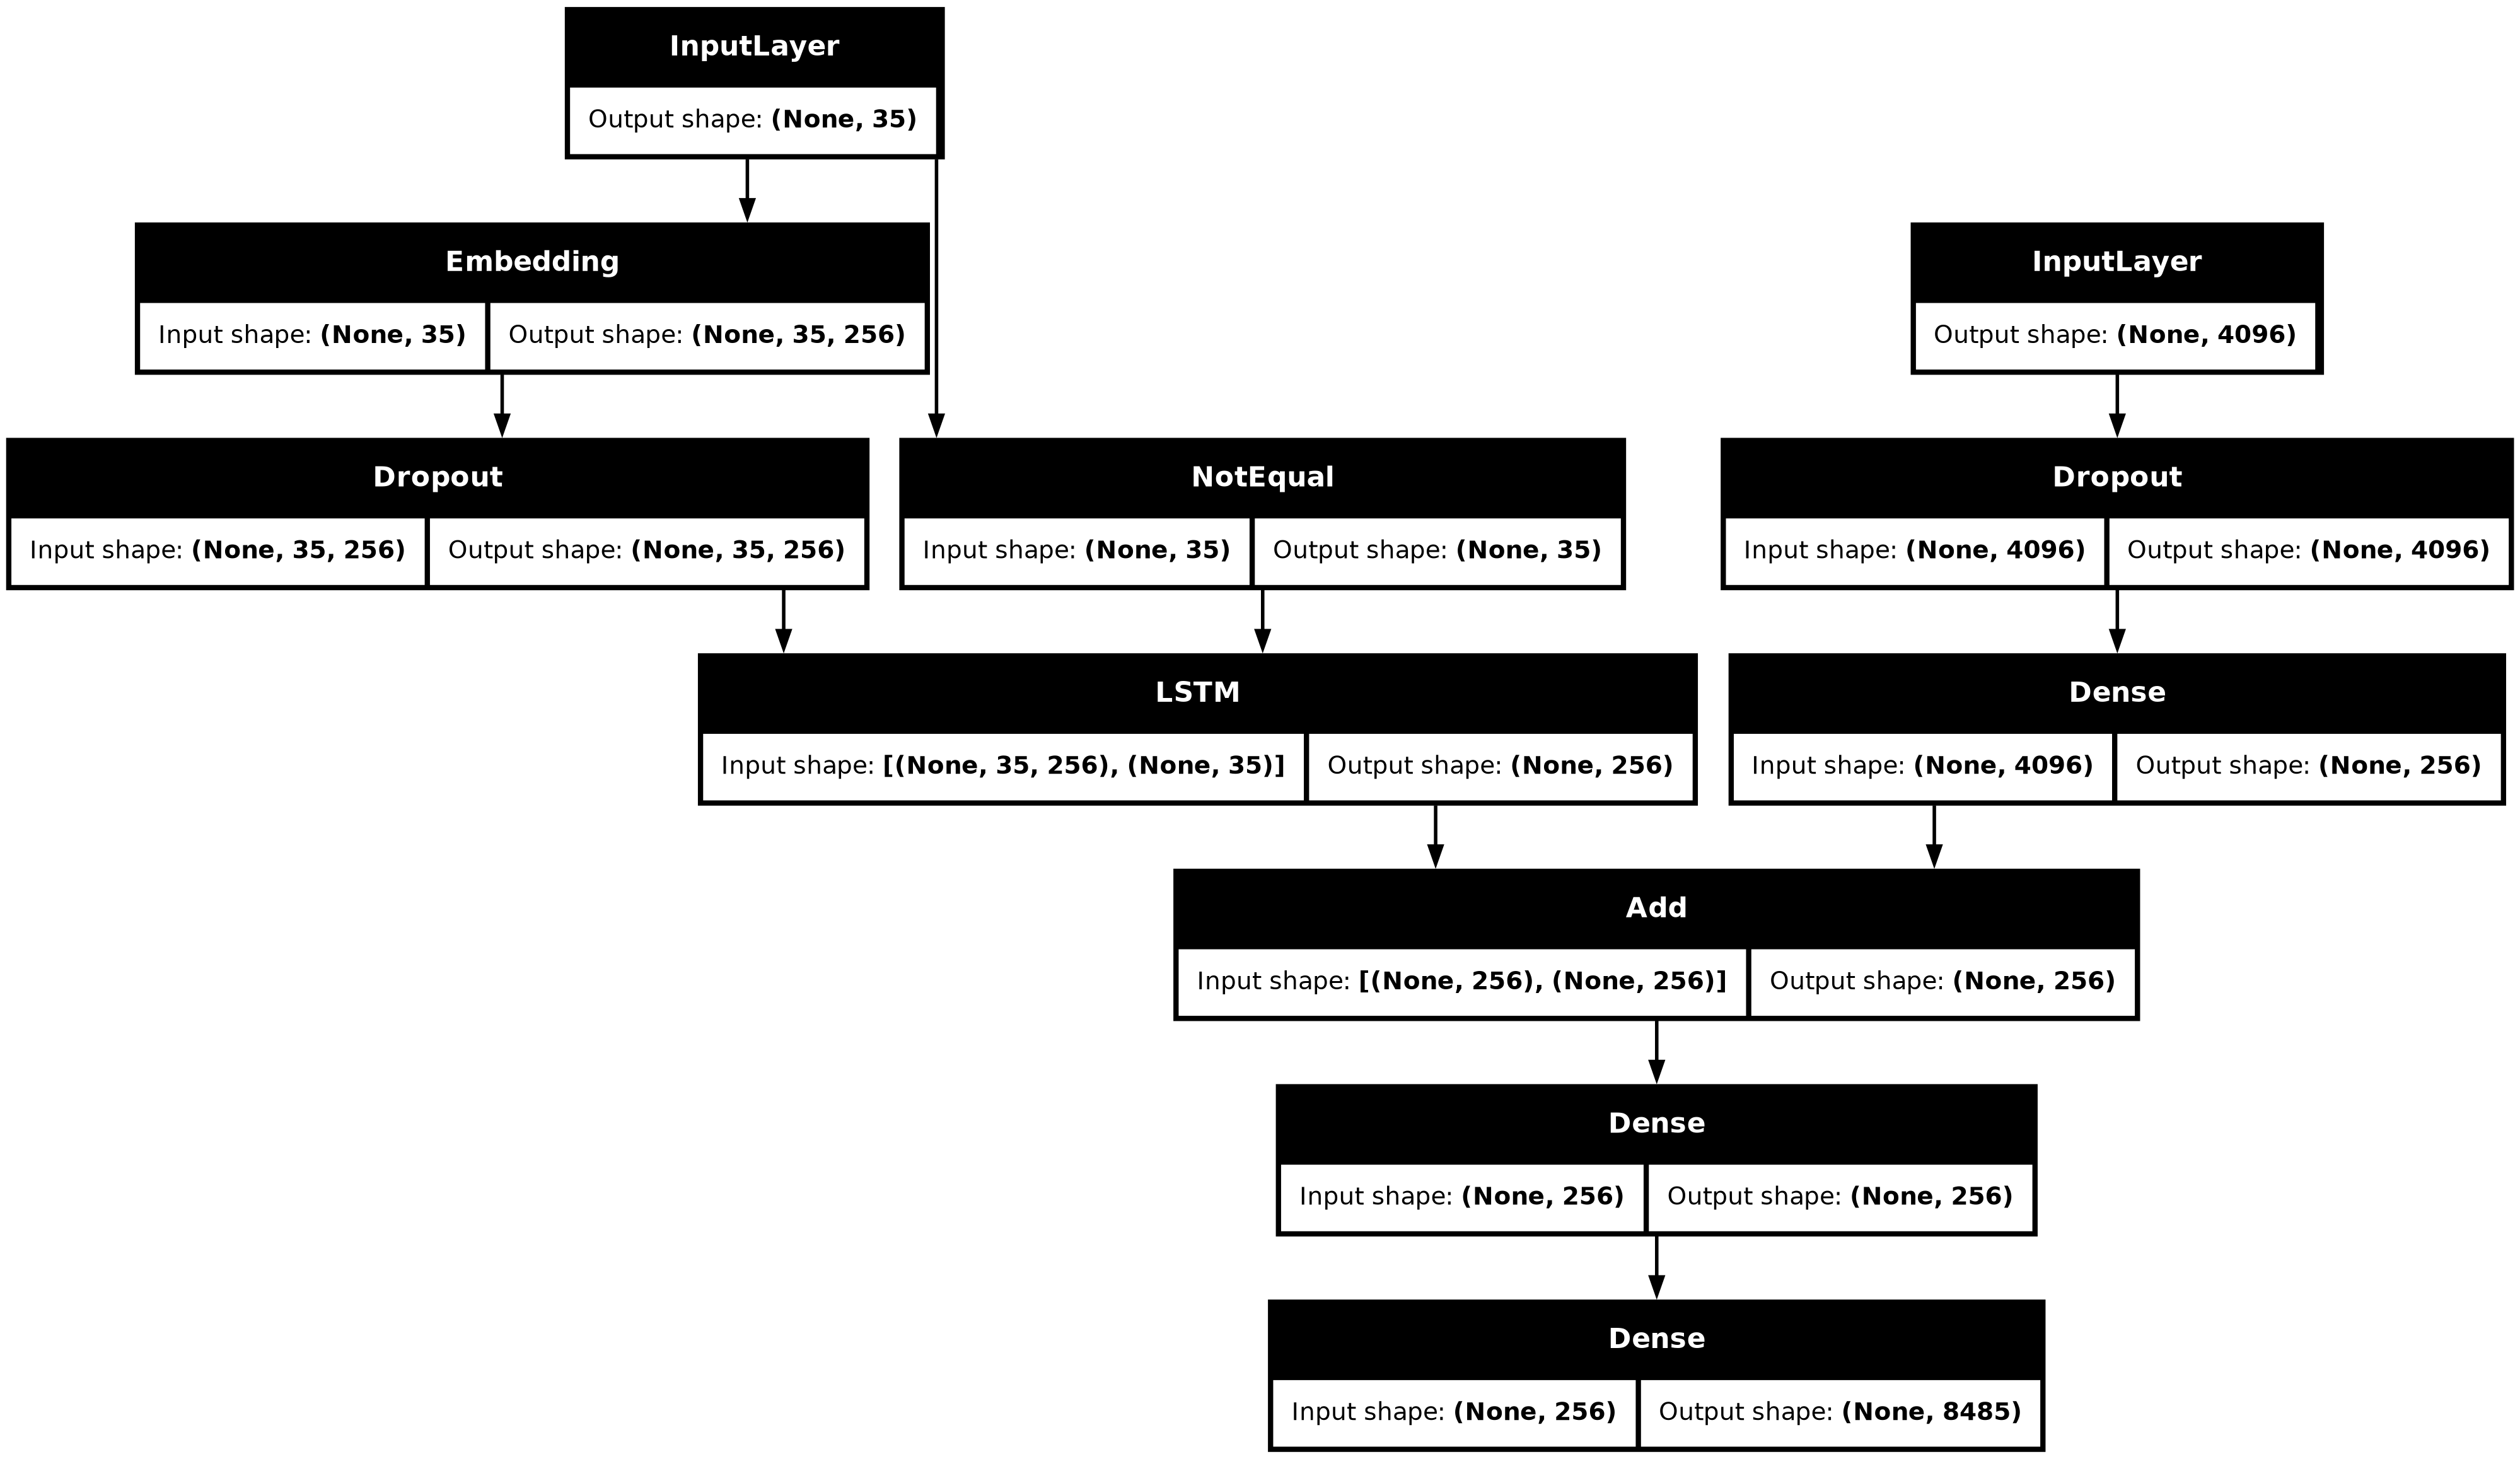

In [23]:
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [24]:
# train model
epochs = 25
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 231ms/step - loss: 5.7739
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 228ms/step - loss: 4.0586
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step - loss: 3.5883
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 227ms/step - loss: 3.3051
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 231ms/step - loss: 3.1034
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step - loss: 2.9508
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step - loss: 2.8311
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 231ms/step - loss: 2.7328
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 228ms/step - loss: 2.6556
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 231ms/step - loss: 2.5864
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 227ms/step - loss: 2.5248
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step - loss: 2.4658
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 233ms/step - loss: 2.4202
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step - loss: 2.3759
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 232ms/step - loss: 2.3360
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 230ms/step - loss: 2.3034
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 231ms/step - loss: 2.27

In [25]:
model.save(WORKING_DIR+'/best_model5.h5')

In [26]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [27]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length, padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [28]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 1/810 [00:00<09:13,  1.46it/s]

BLEU-1: 0.400000
BLEU-2: 0.632456


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 2/810 [00:01<06:45,  1.99it/s]

BLEU-1: 0.500000
BLEU-2: 0.250000


  0%|          | 3/810 [00:01<08:15,  1.63it/s]

BLEU-1: 0.545455
BLEU-2: 0.301511


  0%|          | 4/810 [00:02<08:58,  1.50it/s]

BLEU-1: 0.479167
BLEU-2: 0.233347


  1%|          | 5/810 [00:03<09:53,  1.36it/s]

BLEU-1: 0.446154
BLEU-2: 0.228148


  1%|          | 6/810 [00:03<08:59,  1.49it/s]

BLEU-1: 0.473684
BLEU-2: 0.232670


  1%|          | 7/810 [00:04<08:27,  1.58it/s]

BLEU-1: 0.482759
BLEU-2: 0.257642


  1%|          | 8/810 [00:04<07:33,  1.77it/s]

BLEU-1: 0.479167
BLEU-2: 0.266056


  1%|          | 9/810 [00:05<07:54,  1.69it/s]

BLEU-1: 0.477064
BLEU-2: 0.258436


  1%|          | 10/810 [00:06<07:55,  1.68it/s]

BLEU-1: 0.504132
BLEU-2: 0.285922


  1%|▏         | 11/810 [00:06<07:03,  1.88it/s]

BLEU-1: 0.527132
BLEU-2: 0.313495


  1%|▏         | 12/810 [00:07<07:11,  1.85it/s]

BLEU-1: 0.535714
BLEU-2: 0.316933


  2%|▏         | 13/810 [00:07<07:10,  1.85it/s]

BLEU-1: 0.529801
BLEU-2: 0.303545


  2%|▏         | 14/810 [00:08<07:38,  1.74it/s]

BLEU-1: 0.518293
BLEU-2: 0.293908


  2%|▏         | 15/810 [00:08<07:28,  1.77it/s]

BLEU-1: 0.514286
BLEU-2: 0.289087


  2%|▏         | 16/810 [00:09<08:02,  1.65it/s]

BLEU-1: 0.507937
BLEU-2: 0.286722


  2%|▏         | 17/810 [00:09<06:55,  1.91it/s]

BLEU-1: 0.525510
BLEU-2: 0.306506


  2%|▏         | 18/810 [00:10<07:36,  1.73it/s]

BLEU-1: 0.519048
BLEU-2: 0.311964


  2%|▏         | 19/810 [00:11<08:17,  1.59it/s]

BLEU-1: 0.511111
BLEU-2: 0.302988


  2%|▏         | 20/810 [00:12<08:22,  1.57it/s]

BLEU-1: 0.516807
BLEU-2: 0.311765


  3%|▎         | 21/810 [00:12<08:14,  1.60it/s]

BLEU-1: 0.520000
BLEU-2: 0.308822


  3%|▎         | 22/810 [00:12<06:51,  1.92it/s]

BLEU-1: 0.519531
BLEU-2: 0.308981


  3%|▎         | 23/810 [00:13<07:10,  1.83it/s]

BLEU-1: 0.518657
BLEU-2: 0.305199


  3%|▎         | 24/810 [00:13<06:43,  1.95it/s]

BLEU-1: 0.527076
BLEU-2: 0.319503


  3%|▎         | 25/810 [00:14<06:01,  2.17it/s]

BLEU-1: 0.535211
BLEU-2: 0.327804


  3%|▎         | 26/810 [00:14<05:55,  2.20it/s]

BLEU-1: 0.542662
BLEU-2: 0.337367


  3%|▎         | 27/810 [00:15<05:50,  2.24it/s]

BLEU-1: 0.546358
BLEU-2: 0.333554


  3%|▎         | 28/810 [00:15<05:47,  2.25it/s]

BLEU-1: 0.543408
BLEU-2: 0.330832


  4%|▎         | 29/810 [00:16<05:58,  2.18it/s]

BLEU-1: 0.538941
BLEU-2: 0.327185


  4%|▎         | 30/810 [00:16<06:45,  1.93it/s]

BLEU-1: 0.535928
BLEU-2: 0.325231


  4%|▍         | 31/810 [00:17<07:45,  1.67it/s]

BLEU-1: 0.535817
BLEU-2: 0.325810


  4%|▍         | 32/810 [00:18<08:23,  1.55it/s]

BLEU-1: 0.532967
BLEU-2: 0.318018


  4%|▍         | 33/810 [00:18<07:22,  1.76it/s]

BLEU-1: 0.534946
BLEU-2: 0.315301


  4%|▍         | 34/810 [00:19<07:40,  1.69it/s]

BLEU-1: 0.529870
BLEU-2: 0.313248


  4%|▍         | 35/810 [00:19<06:28,  1.99it/s]

BLEU-1: 0.534527
BLEU-2: 0.314798


  4%|▍         | 36/810 [00:20<07:16,  1.77it/s]

BLEU-1: 0.533333
BLEU-2: 0.315799


  5%|▍         | 37/810 [00:21<08:41,  1.48it/s]

BLEU-1: 0.529551
BLEU-2: 0.316462


  5%|▍         | 38/810 [00:21<08:40,  1.48it/s]

BLEU-1: 0.529817
BLEU-2: 0.313861


  5%|▍         | 39/810 [00:22<07:48,  1.64it/s]

BLEU-1: 0.537079
BLEU-2: 0.321220


  5%|▍         | 40/810 [00:22<07:11,  1.78it/s]

BLEU-1: 0.537445
BLEU-2: 0.320244


  5%|▌         | 41/810 [00:23<07:09,  1.79it/s]

BLEU-1: 0.535484
BLEU-2: 0.319840


  5%|▌         | 42/810 [00:23<06:42,  1.91it/s]

BLEU-1: 0.540084
BLEU-2: 0.320181


  5%|▌         | 43/810 [00:24<06:25,  1.99it/s]

BLEU-1: 0.540373
BLEU-2: 0.319271


  5%|▌         | 44/810 [00:24<06:11,  2.06it/s]

BLEU-1: 0.546748
BLEU-2: 0.327715


  6%|▌         | 45/810 [00:25<06:26,  1.98it/s]

BLEU-1: 0.550696
BLEU-2: 0.332596


  6%|▌         | 46/810 [00:25<05:51,  2.18it/s]

BLEU-1: 0.549020
BLEU-2: 0.331724


  6%|▌         | 47/810 [00:26<06:14,  2.04it/s]

BLEU-1: 0.552783
BLEU-2: 0.336337


  6%|▌         | 48/810 [00:26<05:28,  2.32it/s]

BLEU-1: 0.554080
BLEU-2: 0.338404


  6%|▌         | 49/810 [00:27<06:27,  1.96it/s]

BLEU-1: 0.559259
BLEU-2: 0.340852


  6%|▌         | 50/810 [00:27<07:14,  1.75it/s]

BLEU-1: 0.563177
BLEU-2: 0.345779


  6%|▋         | 51/810 [00:28<06:55,  1.83it/s]

BLEU-1: 0.563055
BLEU-2: 0.344629


  6%|▋         | 52/810 [00:28<07:11,  1.76it/s]

BLEU-1: 0.563478
BLEU-2: 0.342690


  7%|▋         | 53/810 [00:29<07:38,  1.65it/s]

BLEU-1: 0.564626
BLEU-2: 0.340722


  7%|▋         | 54/810 [00:30<07:43,  1.63it/s]

BLEU-1: 0.563333
BLEU-2: 0.341449


  7%|▋         | 55/810 [00:30<07:07,  1.77it/s]

BLEU-1: 0.567434
BLEU-2: 0.346488


  7%|▋         | 56/810 [00:31<07:04,  1.77it/s]

BLEU-1: 0.569579
BLEU-2: 0.350188


  7%|▋         | 57/810 [00:31<07:10,  1.75it/s]

BLEU-1: 0.569157
BLEU-2: 0.346985


  7%|▋         | 58/810 [00:32<07:07,  1.76it/s]

BLEU-1: 0.564063
BLEU-2: 0.342448


  7%|▋         | 59/810 [00:33<07:56,  1.58it/s]

BLEU-1: 0.566412
BLEU-2: 0.341897


  7%|▋         | 60/810 [00:34<08:19,  1.50it/s]

BLEU-1: 0.559043
BLEU-2: 0.336021


  8%|▊         | 61/810 [00:34<07:08,  1.75it/s]

BLEU-1: 0.562130
BLEU-2: 0.340708


  8%|▊         | 62/810 [00:34<06:44,  1.85it/s]

BLEU-1: 0.564964
BLEU-2: 0.342028


  8%|▊         | 63/810 [00:35<07:02,  1.77it/s]

BLEU-1: 0.566714
BLEU-2: 0.343498


  8%|▊         | 64/810 [00:36<07:07,  1.75it/s]

BLEU-1: 0.562147
BLEU-2: 0.339445


  8%|▊         | 65/810 [00:36<06:44,  1.84it/s]

BLEU-1: 0.559275
BLEU-2: 0.336493


  8%|▊         | 66/810 [00:36<06:30,  1.91it/s]

BLEU-1: 0.559229
BLEU-2: 0.334433


  8%|▊         | 67/810 [00:37<06:53,  1.80it/s]

BLEU-1: 0.554201
BLEU-2: 0.330186


  8%|▊         | 68/810 [00:37<06:10,  2.00it/s]

BLEU-1: 0.553020
BLEU-2: 0.328370


  9%|▊         | 69/810 [00:38<05:40,  2.18it/s]

BLEU-1: 0.553191
BLEU-2: 0.329443


  9%|▊         | 70/810 [00:38<05:55,  2.08it/s]

BLEU-1: 0.549869
BLEU-2: 0.326309


  9%|▉         | 71/810 [00:39<06:41,  1.84it/s]

BLEU-1: 0.549677
BLEU-2: 0.324664


  9%|▉         | 72/810 [00:40<06:47,  1.81it/s]

BLEU-1: 0.552163
BLEU-2: 0.327863


  9%|▉         | 73/810 [00:40<07:02,  1.75it/s]

BLEU-1: 0.553885
BLEU-2: 0.327043


  9%|▉         | 74/810 [00:41<07:13,  1.70it/s]

BLEU-1: 0.555556
BLEU-2: 0.330833


  9%|▉         | 75/810 [00:41<06:49,  1.79it/s]

BLEU-1: 0.559219
BLEU-2: 0.336894


  9%|▉         | 76/810 [00:42<06:56,  1.76it/s]

BLEU-1: 0.557831
BLEU-2: 0.336443


 10%|▉         | 77/810 [00:43<06:57,  1.75it/s]

BLEU-1: 0.554102
BLEU-2: 0.333115


 10%|▉         | 78/810 [00:43<06:24,  1.90it/s]

BLEU-1: 0.555948
BLEU-2: 0.335392


 10%|▉         | 79/810 [00:43<06:00,  2.03it/s]

BLEU-1: 0.556593
BLEU-2: 0.335142


 10%|▉         | 80/810 [00:44<05:43,  2.13it/s]

BLEU-1: 0.554913
BLEU-2: 0.333141


 10%|█         | 81/810 [00:45<07:41,  1.58it/s]

BLEU-1: 0.549774
BLEU-2: 0.328899


 10%|█         | 82/810 [00:45<07:41,  1.58it/s]

BLEU-1: 0.547991
BLEU-2: 0.328197


 10%|█         | 83/810 [00:46<07:07,  1.70it/s]

BLEU-1: 0.545856
BLEU-2: 0.325959


 10%|█         | 84/810 [00:46<06:35,  1.84it/s]

BLEU-1: 0.543264
BLEU-2: 0.323808


 10%|█         | 85/810 [00:47<06:21,  1.90it/s]

BLEU-1: 0.543384
BLEU-2: 0.323298


 11%|█         | 86/810 [00:48<07:44,  1.56it/s]

BLEU-1: 0.541001
BLEU-2: 0.320540


 11%|█         | 87/810 [00:48<06:32,  1.84it/s]

BLEU-1: 0.543915
BLEU-2: 0.323418


 11%|█         | 88/810 [00:49<06:51,  1.76it/s]

BLEU-1: 0.539185
BLEU-2: 0.319964


 11%|█         | 89/810 [00:49<06:07,  1.96it/s]

BLEU-1: 0.540456
BLEU-2: 0.322130


 11%|█         | 90/810 [00:49<05:25,  2.21it/s]

BLEU-1: 0.541237
BLEU-2: 0.321445


 11%|█         | 91/810 [00:50<06:52,  1.74it/s]

BLEU-1: 0.536511
BLEU-2: 0.317346


 11%|█▏        | 92/810 [00:51<07:06,  1.68it/s]

BLEU-1: 0.535070
BLEU-2: 0.315925


 11%|█▏        | 93/810 [00:52<08:28,  1.41it/s]

BLEU-1: 0.537402
BLEU-2: 0.321022


 12%|█▏        | 94/810 [00:53<08:24,  1.42it/s]

BLEU-1: 0.537415
BLEU-2: 0.320757


 12%|█▏        | 95/810 [00:53<08:00,  1.49it/s]

BLEU-1: 0.535577
BLEU-2: 0.318509


 12%|█▏        | 96/810 [00:54<07:08,  1.67it/s]

BLEU-1: 0.535305
BLEU-2: 0.318140


 12%|█▏        | 97/810 [00:54<06:18,  1.89it/s]

BLEU-1: 0.536493
BLEU-2: 0.317494


 12%|█▏        | 98/810 [00:55<07:52,  1.51it/s]

BLEU-1: 0.533085
BLEU-2: 0.315451


 12%|█▏        | 99/810 [00:56<08:11,  1.45it/s]

BLEU-1: 0.528059
BLEU-2: 0.311888


 12%|█▏        | 100/810 [00:56<07:02,  1.68it/s]

BLEU-1: 0.530165
BLEU-2: 0.314970


 12%|█▏        | 101/810 [00:57<07:24,  1.59it/s]

BLEU-1: 0.531760
BLEU-2: 0.316024


 13%|█▎        | 102/810 [00:57<07:06,  1.66it/s]

BLEU-1: 0.530576
BLEU-2: 0.315097


 13%|█▎        | 103/810 [00:58<07:18,  1.61it/s]

BLEU-1: 0.531139
BLEU-2: 0.315216


 13%|█▎        | 104/810 [00:58<06:32,  1.80it/s]

BLEU-1: 0.534041
BLEU-2: 0.320063


 13%|█▎        | 105/810 [00:59<07:54,  1.49it/s]

BLEU-1: 0.532230
BLEU-2: 0.317863


 13%|█▎        | 106/810 [01:00<07:40,  1.53it/s]

BLEU-1: 0.532355
BLEU-2: 0.317185


 13%|█▎        | 107/810 [01:00<07:04,  1.65it/s]

BLEU-1: 0.534247
BLEU-2: 0.319714


 13%|█▎        | 108/810 [01:01<07:26,  1.57it/s]

BLEU-1: 0.534293
BLEU-2: 0.319497


 13%|█▎        | 109/810 [01:02<07:18,  1.60it/s]

BLEU-1: 0.532326
BLEU-2: 0.317579


 14%|█▎        | 110/810 [01:02<06:34,  1.78it/s]

BLEU-1: 0.534224
BLEU-2: 0.319579


 14%|█▎        | 111/810 [01:03<07:02,  1.66it/s]

BLEU-1: 0.535537
BLEU-2: 0.320654


 14%|█▍        | 112/810 [01:03<06:26,  1.81it/s]

BLEU-1: 0.537767
BLEU-2: 0.323325


 14%|█▍        | 113/810 [01:04<07:14,  1.61it/s]

BLEU-1: 0.536526
BLEU-2: 0.321816


 14%|█▍        | 114/810 [01:05<07:10,  1.62it/s]

BLEU-1: 0.534996
BLEU-2: 0.320670


 14%|█▍        | 115/810 [01:05<07:39,  1.51it/s]

BLEU-1: 0.534606
BLEU-2: 0.319457


 14%|█▍        | 116/810 [01:06<08:15,  1.40it/s]

BLEU-1: 0.531447
BLEU-2: 0.316577


 14%|█▍        | 117/810 [01:07<08:06,  1.42it/s]

BLEU-1: 0.533489
BLEU-2: 0.318569


 15%|█▍        | 118/810 [01:08<07:45,  1.49it/s]

BLEU-1: 0.533591
BLEU-2: 0.318669


 15%|█▍        | 119/810 [01:08<07:54,  1.46it/s]

BLEU-1: 0.531346
BLEU-2: 0.317095


 15%|█▍        | 120/810 [01:09<08:36,  1.33it/s]

BLEU-1: 0.530211
BLEU-2: 0.314777


 15%|█▍        | 121/810 [01:10<07:55,  1.45it/s]

BLEU-1: 0.531484
BLEU-2: 0.315375


 15%|█▌        | 122/810 [01:10<07:46,  1.47it/s]

BLEU-1: 0.531947
BLEU-2: 0.314783


 15%|█▌        | 123/810 [01:11<07:42,  1.49it/s]

BLEU-1: 0.532401
BLEU-2: 0.316249


 15%|█▌        | 124/810 [01:12<07:05,  1.61it/s]

BLEU-1: 0.531090
BLEU-2: 0.314842


 15%|█▌        | 125/810 [01:12<06:39,  1.71it/s]

BLEU-1: 0.529797
BLEU-2: 0.313451


 16%|█▌        | 126/810 [01:13<06:21,  1.79it/s]

BLEU-1: 0.531408
BLEU-2: 0.316283


 16%|█▌        | 127/810 [01:13<06:43,  1.69it/s]

BLEU-1: 0.528991
BLEU-2: 0.314193


 16%|█▌        | 128/810 [01:14<07:10,  1.59it/s]

BLEU-1: 0.529078
BLEU-2: 0.315373


 16%|█▌        | 129/810 [01:15<07:03,  1.61it/s]

BLEU-1: 0.527094
BLEU-2: 0.313560


 16%|█▌        | 130/810 [01:15<06:16,  1.81it/s]

BLEU-1: 0.527311
BLEU-2: 0.313548


 16%|█▌        | 131/810 [01:16<06:38,  1.70it/s]

BLEU-1: 0.529167
BLEU-2: 0.314709


 16%|█▋        | 132/810 [01:16<06:44,  1.68it/s]

BLEU-1: 0.529290
BLEU-2: 0.314190


 16%|█▋        | 133/810 [01:17<06:59,  1.61it/s]

BLEU-1: 0.529050
BLEU-2: 0.313452


 17%|█▋        | 134/810 [01:18<07:51,  1.43it/s]

BLEU-1: 0.527383
BLEU-2: 0.311208


 17%|█▋        | 135/810 [01:18<07:21,  1.53it/s]

BLEU-1: 0.527871
BLEU-2: 0.310943


 17%|█▋        | 136/810 [01:19<07:01,  1.60it/s]

BLEU-1: 0.528352
BLEU-2: 0.311303


 17%|█▋        | 137/810 [01:20<08:04,  1.39it/s]

BLEU-1: 0.529024
BLEU-2: 0.313383


 17%|█▋        | 138/810 [01:20<07:50,  1.43it/s]

BLEU-1: 0.526832
BLEU-2: 0.311493


 17%|█▋        | 139/810 [01:21<07:32,  1.48it/s]

BLEU-1: 0.526966
BLEU-2: 0.311628


 17%|█▋        | 140/810 [01:22<07:29,  1.49it/s]

BLEU-1: 0.527402
BLEU-2: 0.312938


 17%|█▋        | 141/810 [01:23<07:48,  1.43it/s]

BLEU-1: 0.527796
BLEU-2: 0.312216


 18%|█▊        | 142/810 [01:23<08:13,  1.35it/s]

BLEU-1: 0.527848
BLEU-2: 0.311298


 18%|█▊        | 143/810 [01:24<07:59,  1.39it/s]

BLEU-1: 0.528266
BLEU-2: 0.310824


 18%|█▊        | 144/810 [01:24<07:04,  1.57it/s]

BLEU-1: 0.527500
BLEU-2: 0.309851


 18%|█▊        | 145/810 [01:25<07:09,  1.55it/s]

BLEU-1: 0.528536
BLEU-2: 0.310154


 18%|█▊        | 146/810 [01:26<07:14,  1.53it/s]

BLEU-1: 0.527094
BLEU-2: 0.308576


 18%|█▊        | 147/810 [01:26<07:22,  1.50it/s]

BLEU-1: 0.528117
BLEU-2: 0.310029


 18%|█▊        | 148/810 [01:27<06:39,  1.66it/s]

BLEU-1: 0.529197
BLEU-2: 0.311328


 18%|█▊        | 149/810 [01:28<06:30,  1.69it/s]

BLEU-1: 0.530230
BLEU-2: 0.311830


 19%|█▊        | 150/810 [01:28<06:03,  1.82it/s]

BLEU-1: 0.530686
BLEU-2: 0.312367


 19%|█▊        | 151/810 [01:29<06:37,  1.66it/s]

BLEU-1: 0.531940
BLEU-2: 0.312621


 19%|█▉        | 152/810 [01:29<06:13,  1.76it/s]

BLEU-1: 0.532977
BLEU-2: 0.313322


 19%|█▉        | 153/810 [01:30<06:55,  1.58it/s]

BLEU-1: 0.533883
BLEU-2: 0.314472


 19%|█▉        | 154/810 [01:30<05:57,  1.83it/s]

BLEU-1: 0.533764
BLEU-2: 0.314478


 19%|█▉        | 155/810 [01:31<06:21,  1.72it/s]

BLEU-1: 0.533528
BLEU-2: 0.314387


 19%|█▉        | 156/810 [01:31<06:05,  1.79it/s]

BLEU-1: 0.533063
BLEU-2: 0.313989


 19%|█▉        | 157/810 [01:32<06:07,  1.78it/s]

BLEU-1: 0.534025
BLEU-2: 0.314454


 20%|█▉        | 158/810 [01:33<06:27,  1.68it/s]

BLEU-1: 0.535510
BLEU-2: 0.315406


 20%|█▉        | 159/810 [01:34<07:40,  1.41it/s]

BLEU-1: 0.534620
BLEU-2: 0.314727


 20%|█▉        | 160/810 [01:34<06:43,  1.61it/s]

BLEU-1: 0.535896
BLEU-2: 0.316099


 20%|█▉        | 161/810 [01:35<07:03,  1.53it/s]

BLEU-1: 0.535915
BLEU-2: 0.315980


 20%|██        | 162/810 [01:36<07:40,  1.41it/s]

BLEU-1: 0.533111
BLEU-2: 0.313800


 20%|██        | 163/810 [01:36<07:47,  1.38it/s]

BLEU-1: 0.532597
BLEU-2: 0.313537


 20%|██        | 164/810 [01:37<07:16,  1.48it/s]

BLEU-1: 0.534066
BLEU-2: 0.315168


 20%|██        | 165/810 [01:38<07:16,  1.48it/s]

BLEU-1: 0.533843
BLEU-2: 0.314571


 20%|██        | 166/810 [01:38<07:14,  1.48it/s]

BLEU-1: 0.533080
BLEU-2: 0.313314


 21%|██        | 167/810 [01:39<07:29,  1.43it/s]

BLEU-1: 0.532041
BLEU-2: 0.311895


 21%|██        | 168/810 [01:40<07:26,  1.44it/s]

BLEU-1: 0.531835
BLEU-2: 0.310825


 21%|██        | 169/810 [01:41<07:50,  1.36it/s]

BLEU-1: 0.531316
BLEU-2: 0.309903


 21%|██        | 170/810 [01:41<07:29,  1.42it/s]

BLEU-1: 0.531398
BLEU-2: 0.309027


 21%|██        | 171/810 [01:42<06:45,  1.57it/s]

BLEU-1: 0.531266
BLEU-2: 0.308861


 21%|██        | 172/810 [01:42<06:42,  1.58it/s]

BLEU-1: 0.529781
BLEU-2: 0.307542


 21%|██▏       | 173/810 [01:43<06:19,  1.68it/s]

BLEU-1: 0.529381
BLEU-2: 0.307215


 21%|██▏       | 174/810 [01:43<06:02,  1.75it/s]

BLEU-1: 0.530538
BLEU-2: 0.308811


 22%|██▏       | 175/810 [01:44<05:50,  1.81it/s]

BLEU-1: 0.530139
BLEU-2: 0.307995


 22%|██▏       | 176/810 [01:45<06:33,  1.61it/s]

BLEU-1: 0.528900
BLEU-2: 0.306993


 22%|██▏       | 177/810 [01:45<07:06,  1.48it/s]

BLEU-1: 0.530218
BLEU-2: 0.307223


 22%|██▏       | 178/810 [01:46<06:44,  1.56it/s]

BLEU-1: 0.531582
BLEU-2: 0.307809


 22%|██▏       | 179/810 [01:46<06:04,  1.73it/s]

BLEU-1: 0.532226
BLEU-2: 0.307962


 22%|██▏       | 180/810 [01:47<05:21,  1.96it/s]

BLEU-1: 0.532129
BLEU-2: 0.307986


 22%|██▏       | 181/810 [01:47<05:01,  2.08it/s]

BLEU-1: 0.532766
BLEU-2: 0.308137


 22%|██▏       | 182/810 [01:48<05:30,  1.90it/s]

BLEU-1: 0.532836
BLEU-2: 0.307787


 23%|██▎       | 183/810 [01:48<04:57,  2.10it/s]

BLEU-1: 0.533234
BLEU-2: 0.308426


 23%|██▎       | 184/810 [01:49<05:26,  1.92it/s]

BLEU-1: 0.535767
BLEU-2: 0.311601


 23%|██▎       | 185/810 [01:50<06:12,  1.68it/s]

BLEU-1: 0.534804
BLEU-2: 0.311240


 23%|██▎       | 186/810 [01:50<05:46,  1.80it/s]

BLEU-1: 0.535156
BLEU-2: 0.312141


 23%|██▎       | 187/810 [01:51<06:40,  1.56it/s]

BLEU-1: 0.535143
BLEU-2: 0.311886


 23%|██▎       | 188/810 [01:51<06:18,  1.64it/s]

BLEU-1: 0.536680
BLEU-2: 0.314399


 23%|██▎       | 189/810 [01:52<06:22,  1.62it/s]

BLEU-1: 0.537206
BLEU-2: 0.314625


 23%|██▎       | 190/810 [01:53<05:53,  1.76it/s]

BLEU-1: 0.536585
BLEU-2: 0.313864


 24%|██▎       | 191/810 [01:53<06:01,  1.71it/s]

BLEU-1: 0.537583
BLEU-2: 0.314229


 24%|██▎       | 192/810 [01:54<06:10,  1.67it/s]

BLEU-1: 0.536678
BLEU-2: 0.313146


 24%|██▍       | 193/810 [01:54<06:27,  1.59it/s]

BLEU-1: 0.537412
BLEU-2: 0.313799


 24%|██▍       | 194/810 [01:55<06:47,  1.51it/s]

BLEU-1: 0.537886
BLEU-2: 0.312967


 24%|██▍       | 195/810 [01:56<06:43,  1.53it/s]

BLEU-1: 0.538390
BLEU-2: 0.314071


 24%|██▍       | 196/810 [01:57<06:42,  1.53it/s]

BLEU-1: 0.536574
BLEU-2: 0.312742


 24%|██▍       | 197/810 [01:57<05:48,  1.76it/s]

BLEU-1: 0.536934
BLEU-2: 0.312885


 24%|██▍       | 198/810 [01:58<06:29,  1.57it/s]

BLEU-1: 0.534862
BLEU-2: 0.311255


 25%|██▍       | 199/810 [01:59<07:18,  1.39it/s]

BLEU-1: 0.533698
BLEU-2: 0.309746


 25%|██▍       | 200/810 [01:59<06:53,  1.48it/s]

BLEU-1: 0.533998
BLEU-2: 0.309568


 25%|██▍       | 201/810 [02:00<07:24,  1.37it/s]

BLEU-1: 0.532883
BLEU-2: 0.308247


 25%|██▍       | 202/810 [02:01<07:26,  1.36it/s]

BLEU-1: 0.533811
BLEU-2: 0.309307


 25%|██▌       | 203/810 [02:02<08:09,  1.24it/s]

BLEU-1: 0.532000
BLEU-2: 0.307573


 25%|██▌       | 204/810 [02:02<07:17,  1.39it/s]

BLEU-1: 0.532094
BLEU-2: 0.308263


 25%|██▌       | 205/810 [02:03<07:19,  1.38it/s]

BLEU-1: 0.531690
BLEU-2: 0.307668


 25%|██▌       | 206/810 [02:04<07:02,  1.43it/s]

BLEU-1: 0.531318
BLEU-2: 0.307652


 26%|██▌       | 207/810 [02:04<07:11,  1.40it/s]

BLEU-1: 0.531155
BLEU-2: 0.308035


 26%|██▌       | 208/810 [02:05<07:24,  1.35it/s]

BLEU-1: 0.531629
BLEU-2: 0.309343


 26%|██▌       | 209/810 [02:06<07:39,  1.31it/s]

BLEU-1: 0.530146
BLEU-2: 0.307960


 26%|██▌       | 210/810 [02:07<08:00,  1.25it/s]

BLEU-1: 0.530595
BLEU-2: 0.308695


 26%|██▌       | 211/810 [02:07<07:12,  1.38it/s]

BLEU-1: 0.530691
BLEU-2: 0.309351


 26%|██▌       | 212/810 [02:08<08:07,  1.23it/s]

BLEU-1: 0.528342
BLEU-2: 0.307444


 26%|██▋       | 213/810 [02:09<07:17,  1.36it/s]

BLEU-1: 0.528024
BLEU-2: 0.307180


 26%|██▋       | 214/810 [02:10<07:12,  1.38it/s]

BLEU-1: 0.529560
BLEU-2: 0.309616


 27%|██▋       | 215/810 [02:10<07:15,  1.37it/s]

BLEU-1: 0.529608
BLEU-2: 0.308778


 27%|██▋       | 216/810 [02:11<06:38,  1.49it/s]

BLEU-1: 0.529290
BLEU-2: 0.308904


 27%|██▋       | 217/810 [02:12<06:34,  1.50it/s]

BLEU-1: 0.529363
BLEU-2: 0.308613


 27%|██▋       | 218/810 [02:12<06:39,  1.48it/s]

BLEU-1: 0.528395
BLEU-2: 0.307951


 27%|██▋       | 219/810 [02:13<06:04,  1.62it/s]

BLEU-1: 0.529532
BLEU-2: 0.309343


 27%|██▋       | 220/810 [02:13<05:49,  1.69it/s]

BLEU-1: 0.529219
BLEU-2: 0.308695


 27%|██▋       | 221/810 [02:14<06:18,  1.56it/s]

BLEU-1: 0.529268
BLEU-2: 0.308648


 27%|██▋       | 222/810 [02:15<06:55,  1.41it/s]

BLEU-1: 0.529293
BLEU-2: 0.308076


 28%|██▊       | 223/810 [02:16<06:55,  1.41it/s]

BLEU-1: 0.529152
BLEU-2: 0.308045


 28%|██▊       | 224/810 [02:16<06:25,  1.52it/s]

BLEU-1: 0.528846
BLEU-2: 0.307414


 28%|██▊       | 225/810 [02:17<06:35,  1.48it/s]

BLEU-1: 0.529107
BLEU-2: 0.307879


 28%|██▊       | 226/810 [02:18<06:47,  1.43it/s]

BLEU-1: 0.528362
BLEU-2: 0.307606


 28%|██▊       | 227/810 [02:18<06:18,  1.54it/s]

BLEU-1: 0.528854
BLEU-2: 0.307961


 28%|██▊       | 228/810 [02:19<05:38,  1.72it/s]

BLEU-1: 0.529365
BLEU-2: 0.308454


 28%|██▊       | 229/810 [02:19<05:20,  1.81it/s]

BLEU-1: 0.529273
BLEU-2: 0.308331


 28%|██▊       | 230/810 [02:20<06:23,  1.51it/s]

BLEU-1: 0.528700
BLEU-2: 0.307540


 29%|██▊       | 231/810 [02:21<06:56,  1.39it/s]

BLEU-1: 0.527562
BLEU-2: 0.306657


 29%|██▊       | 232/810 [02:21<06:24,  1.50it/s]

BLEU-1: 0.528046
BLEU-2: 0.307738


 29%|██▉       | 233/810 [02:22<05:55,  1.62it/s]

BLEU-1: 0.528346
BLEU-2: 0.308096


 29%|██▉       | 234/810 [02:23<06:28,  1.48it/s]

BLEU-1: 0.528960
BLEU-2: 0.308154


 29%|██▉       | 235/810 [02:23<05:26,  1.76it/s]

BLEU-1: 0.529096
BLEU-2: 0.307934


 29%|██▉       | 236/810 [02:24<05:31,  1.73it/s]

BLEU-1: 0.528223
BLEU-2: 0.307099


 29%|██▉       | 237/810 [02:24<05:25,  1.76it/s]

BLEU-1: 0.527936
BLEU-2: 0.306862


 29%|██▉       | 238/810 [02:25<05:59,  1.59it/s]

BLEU-1: 0.528744
BLEU-2: 0.307404


 30%|██▉       | 239/810 [02:26<06:21,  1.50it/s]

BLEU-1: 0.528416
BLEU-2: 0.306901


 30%|██▉       | 240/810 [02:26<06:23,  1.49it/s]

BLEU-1: 0.527361
BLEU-2: 0.305963


 30%|██▉       | 241/810 [02:27<07:24,  1.28it/s]

BLEU-1: 0.526433
BLEU-2: 0.305687


 30%|██▉       | 242/810 [02:28<06:44,  1.40it/s]

BLEU-1: 0.525788
BLEU-2: 0.305001


 30%|███       | 243/810 [02:29<07:38,  1.24it/s]

BLEU-1: 0.525617
BLEU-2: 0.304600


 30%|███       | 244/810 [02:30<06:52,  1.37it/s]

BLEU-1: 0.525716
BLEU-2: 0.304833


 30%|███       | 245/810 [02:30<06:59,  1.35it/s]

BLEU-1: 0.525046
BLEU-2: 0.304250


 30%|███       | 246/810 [02:31<07:18,  1.29it/s]

BLEU-1: 0.524918
BLEU-2: 0.303422


 30%|███       | 247/810 [02:32<06:56,  1.35it/s]

BLEU-1: 0.526087
BLEU-2: 0.303845


 31%|███       | 248/810 [02:33<06:58,  1.34it/s]

BLEU-1: 0.525784
BLEU-2: 0.303378


 31%|███       | 249/810 [02:33<06:41,  1.40it/s]

BLEU-1: 0.525862
BLEU-2: 0.303144


 31%|███       | 250/810 [02:34<06:58,  1.34it/s]

BLEU-1: 0.526090
BLEU-2: 0.302435


 31%|███       | 251/810 [02:35<07:07,  1.31it/s]

BLEU-1: 0.525960
BLEU-2: 0.301970


 31%|███       | 252/810 [02:36<07:30,  1.24it/s]

BLEU-1: 0.525646
BLEU-2: 0.301057


 31%|███       | 253/810 [02:36<06:46,  1.37it/s]

BLEU-1: 0.526984
BLEU-2: 0.303059


 31%|███▏      | 254/810 [02:37<06:24,  1.45it/s]

BLEU-1: 0.526723
BLEU-2: 0.302515


 31%|███▏      | 255/810 [02:38<06:16,  1.47it/s]

BLEU-1: 0.527496
BLEU-2: 0.303828


 32%|███▏      | 256/810 [02:38<06:28,  1.42it/s]

BLEU-1: 0.527197
BLEU-2: 0.304041


 32%|███▏      | 257/810 [02:39<05:44,  1.61it/s]

BLEU-1: 0.526957
BLEU-2: 0.303623


 32%|███▏      | 258/810 [02:40<06:24,  1.44it/s]

BLEU-1: 0.525952
BLEU-2: 0.302526


 32%|███▏      | 259/810 [02:40<05:57,  1.54it/s]

BLEU-1: 0.525699
BLEU-2: 0.302653


 32%|███▏      | 260/810 [02:41<06:04,  1.51it/s]

BLEU-1: 0.524906
BLEU-2: 0.302452


 32%|███▏      | 261/810 [02:41<05:17,  1.73it/s]

BLEU-1: 0.525540
BLEU-2: 0.302350


 32%|███▏      | 262/810 [02:42<05:39,  1.62it/s]

BLEU-1: 0.525435
BLEU-2: 0.302348


 32%|███▏      | 263/810 [02:43<05:43,  1.59it/s]

BLEU-1: 0.524830
BLEU-2: 0.301609


 33%|███▎      | 264/810 [02:43<05:29,  1.66it/s]

BLEU-1: 0.525263
BLEU-2: 0.302579


 33%|███▎      | 265/810 [02:44<05:11,  1.75it/s]

BLEU-1: 0.526209
BLEU-2: 0.303425


 33%|███▎      | 266/810 [02:44<04:58,  1.82it/s]

BLEU-1: 0.526813
BLEU-2: 0.304170


 33%|███▎      | 267/810 [02:45<06:15,  1.45it/s]

BLEU-1: 0.525981
BLEU-2: 0.302977


 33%|███▎      | 268/810 [02:46<05:51,  1.54it/s]

BLEU-1: 0.526404
BLEU-2: 0.303291


 33%|███▎      | 269/810 [02:47<06:23,  1.41it/s]

BLEU-1: 0.525615
BLEU-2: 0.302343


 33%|███▎      | 270/810 [02:47<06:05,  1.48it/s]

BLEU-1: 0.525862
BLEU-2: 0.302235


 33%|███▎      | 271/810 [02:48<05:47,  1.55it/s]

BLEU-1: 0.525620
BLEU-2: 0.301726


 34%|███▎      | 272/810 [02:48<05:40,  1.58it/s]

BLEU-1: 0.525535
BLEU-2: 0.301210


 34%|███▎      | 273/810 [02:49<06:02,  1.48it/s]

BLEU-1: 0.524934
BLEU-2: 0.300386


 34%|███▍      | 274/810 [02:50<05:58,  1.49it/s]

BLEU-1: 0.525335
BLEU-2: 0.300589


 34%|███▍      | 275/810 [02:51<06:21,  1.40it/s]

BLEU-1: 0.525545
BLEU-2: 0.301200


 34%|███▍      | 276/810 [02:51<05:55,  1.50it/s]

BLEU-1: 0.525633
BLEU-2: 0.300795


 34%|███▍      | 277/810 [02:52<06:30,  1.36it/s]

BLEU-1: 0.525024
BLEU-2: 0.299874


 34%|███▍      | 278/810 [02:53<05:52,  1.51it/s]

BLEU-1: 0.525282
BLEU-2: 0.299886


 34%|███▍      | 279/810 [02:53<05:32,  1.60it/s]

BLEU-1: 0.525690
BLEU-2: 0.299888


 35%|███▍      | 280/810 [02:54<05:47,  1.53it/s]

BLEU-1: 0.525272
BLEU-2: 0.299497


 35%|███▍      | 281/810 [02:55<06:04,  1.45it/s]

BLEU-1: 0.526601
BLEU-2: 0.301087


 35%|███▍      | 282/810 [02:56<07:19,  1.20it/s]

BLEU-1: 0.526116
BLEU-2: 0.300866


 35%|███▍      | 283/810 [02:56<06:26,  1.37it/s]

BLEU-1: 0.526997
BLEU-2: 0.301056


 35%|███▌      | 284/810 [02:57<06:25,  1.36it/s]

BLEU-1: 0.527524
BLEU-2: 0.302447


 35%|███▌      | 285/810 [02:58<06:32,  1.34it/s]

BLEU-1: 0.528195
BLEU-2: 0.302915


 35%|███▌      | 286/810 [02:58<06:15,  1.40it/s]

BLEU-1: 0.528732
BLEU-2: 0.303199


 35%|███▌      | 287/810 [02:59<05:49,  1.50it/s]

BLEU-1: 0.528807
BLEU-2: 0.303700


 36%|███▌      | 288/810 [03:00<06:24,  1.36it/s]

BLEU-1: 0.527588
BLEU-2: 0.302626


 36%|███▌      | 289/810 [03:01<06:36,  1.31it/s]

BLEU-1: 0.527778
BLEU-2: 0.302605


 36%|███▌      | 290/810 [03:02<06:48,  1.27it/s]

BLEU-1: 0.528743
BLEU-2: 0.303152


 36%|███▌      | 291/810 [03:02<05:45,  1.50it/s]

BLEU-1: 0.529303
BLEU-2: 0.303645


 36%|███▌      | 292/810 [03:03<05:53,  1.46it/s]

BLEU-1: 0.529807
BLEU-2: 0.304691


 36%|███▌      | 293/810 [03:03<06:08,  1.40it/s]

BLEU-1: 0.530811
BLEU-2: 0.305838


 36%|███▋      | 294/810 [03:04<05:45,  1.49it/s]

BLEU-1: 0.530879
BLEU-2: 0.306318


 36%|███▋      | 295/810 [03:05<06:09,  1.39it/s]

BLEU-1: 0.531051
BLEU-2: 0.305993


 37%|███▋      | 296/810 [03:05<05:54,  1.45it/s]

BLEU-1: 0.530655
BLEU-2: 0.305422


 37%|███▋      | 297/810 [03:07<06:48,  1.26it/s]

BLEU-1: 0.531250
BLEU-2: 0.306506


 37%|███▋      | 298/810 [03:07<06:54,  1.23it/s]

BLEU-1: 0.530679
BLEU-2: 0.306307


 37%|███▋      | 299/810 [03:08<06:49,  1.25it/s]

BLEU-1: 0.530570
BLEU-2: 0.305723


 37%|███▋      | 300/810 [03:09<06:05,  1.40it/s]

BLEU-1: 0.530497
BLEU-2: 0.305352


 37%|███▋      | 301/810 [03:09<05:59,  1.42it/s]

BLEU-1: 0.530249
BLEU-2: 0.305349


 37%|███▋      | 302/810 [03:10<06:22,  1.33it/s]

BLEU-1: 0.530124
BLEU-2: 0.305514


 37%|███▋      | 303/810 [03:11<06:25,  1.32it/s]

BLEU-1: 0.530156
BLEU-2: 0.305492


 38%|███▊      | 304/810 [03:12<06:47,  1.24it/s]

BLEU-1: 0.528998
BLEU-2: 0.304750


 38%|███▊      | 305/810 [03:13<07:00,  1.20it/s]

BLEU-1: 0.529600
BLEU-2: 0.304796


 38%|███▊      | 306/810 [03:14<07:19,  1.15it/s]

BLEU-1: 0.529463
BLEU-2: 0.304027


 38%|███▊      | 307/810 [03:15<07:14,  1.16it/s]

BLEU-1: 0.529922
BLEU-2: 0.304084


 38%|███▊      | 308/810 [03:15<07:19,  1.14it/s]

BLEU-1: 0.529361
BLEU-2: 0.303526


 38%|███▊      | 309/810 [03:16<06:32,  1.28it/s]

BLEU-1: 0.529716
BLEU-2: 0.304070


 38%|███▊      | 310/810 [03:17<07:06,  1.17it/s]

BLEU-1: 0.529714
BLEU-2: 0.304126


 38%|███▊      | 311/810 [03:18<06:14,  1.33it/s]

BLEU-1: 0.529076
BLEU-2: 0.303610


 39%|███▊      | 312/810 [03:18<06:05,  1.36it/s]

BLEU-1: 0.528843
BLEU-2: 0.303341


 39%|███▊      | 313/810 [03:19<06:03,  1.37it/s]

BLEU-1: 0.528745
BLEU-2: 0.303065


 39%|███▉      | 314/810 [03:20<06:02,  1.37it/s]

BLEU-1: 0.529495
BLEU-2: 0.304114


 39%|███▉      | 315/810 [03:20<06:03,  1.36it/s]

BLEU-1: 0.528833
BLEU-2: 0.303407


 39%|███▉      | 316/810 [03:21<05:55,  1.39it/s]

BLEU-1: 0.528603
BLEU-2: 0.303411


 39%|███▉      | 317/810 [03:22<06:21,  1.29it/s]

BLEU-1: 0.528344
BLEU-2: 0.303487


 39%|███▉      | 318/810 [03:23<05:53,  1.39it/s]

BLEU-1: 0.529526
BLEU-2: 0.305580


 39%|███▉      | 319/810 [03:23<05:46,  1.42it/s]

BLEU-1: 0.529020
BLEU-2: 0.304968


 40%|███▉      | 320/810 [03:24<05:49,  1.40it/s]

BLEU-1: 0.529477
BLEU-2: 0.305907


 40%|███▉      | 321/810 [03:25<05:19,  1.53it/s]

BLEU-1: 0.529412
BLEU-2: 0.306088


 40%|███▉      | 322/810 [03:25<05:47,  1.40it/s]

BLEU-1: 0.528748
BLEU-2: 0.305557


 40%|███▉      | 323/810 [03:26<06:06,  1.33it/s]

BLEU-1: 0.529186
BLEU-2: 0.306126


 40%|████      | 324/810 [03:27<06:38,  1.22it/s]

BLEU-1: 0.528786
BLEU-2: 0.305841


 40%|████      | 325/810 [03:28<06:03,  1.33it/s]

BLEU-1: 0.528851
BLEU-2: 0.306269


 40%|████      | 326/810 [03:29<06:30,  1.24it/s]

BLEU-1: 0.529810
BLEU-2: 0.307147


 40%|████      | 327/810 [03:30<06:35,  1.22it/s]

BLEU-1: 0.529158
BLEU-2: 0.306622


 40%|████      | 328/810 [03:30<06:13,  1.29it/s]

BLEU-1: 0.528937
BLEU-2: 0.306105


 41%|████      | 329/810 [03:31<06:23,  1.25it/s]

BLEU-1: 0.529096
BLEU-2: 0.306074


 41%|████      | 330/810 [03:32<06:46,  1.18it/s]

BLEU-1: 0.528705
BLEU-2: 0.305288


 41%|████      | 331/810 [03:33<06:24,  1.25it/s]

BLEU-1: 0.528628
BLEU-2: 0.304864


 41%|████      | 332/810 [03:33<06:07,  1.30it/s]

BLEU-1: 0.528943
BLEU-2: 0.305016


 41%|████      | 333/810 [03:34<05:48,  1.37it/s]

BLEU-1: 0.528337
BLEU-2: 0.304443


 41%|████      | 334/810 [03:35<05:17,  1.50it/s]

BLEU-1: 0.528277
BLEU-2: 0.304619


 41%|████▏     | 335/810 [03:35<05:26,  1.46it/s]

BLEU-1: 0.527661
BLEU-2: 0.303958


 41%|████▏     | 336/810 [03:36<04:47,  1.65it/s]

BLEU-1: 0.527617
BLEU-2: 0.303726


 42%|████▏     | 337/810 [03:37<05:00,  1.57it/s]

BLEU-1: 0.527669
BLEU-2: 0.303803


 42%|████▏     | 338/810 [03:37<05:23,  1.46it/s]

BLEU-1: 0.527967
BLEU-2: 0.304113


 42%|████▏     | 339/810 [03:38<05:00,  1.57it/s]

BLEU-1: 0.527908
BLEU-2: 0.304040


 42%|████▏     | 340/810 [03:39<06:02,  1.30it/s]

BLEU-1: 0.526616
BLEU-2: 0.302976


 42%|████▏     | 341/810 [03:40<06:19,  1.24it/s]

BLEU-1: 0.526261
BLEU-2: 0.302314


 42%|████▏     | 342/810 [03:41<06:08,  1.27it/s]

BLEU-1: 0.526180
BLEU-2: 0.302313


 42%|████▏     | 343/810 [03:41<05:30,  1.41it/s]

BLEU-1: 0.526126
BLEU-2: 0.302244


 42%|████▏     | 344/810 [03:42<05:46,  1.35it/s]

BLEU-1: 0.525654
BLEU-2: 0.301598


 43%|████▎     | 345/810 [03:43<05:52,  1.32it/s]

BLEU-1: 0.525697
BLEU-2: 0.301347


 43%|████▎     | 346/810 [03:44<06:03,  1.28it/s]

BLEU-1: 0.525605
BLEU-2: 0.300773


 43%|████▎     | 347/810 [03:45<06:48,  1.13it/s]

BLEU-1: 0.525101
BLEU-2: 0.300119


 43%|████▎     | 348/810 [03:45<06:13,  1.24it/s]

BLEU-1: 0.525544
BLEU-2: 0.300841


 43%|████▎     | 349/810 [03:46<06:19,  1.22it/s]

BLEU-1: 0.524698
BLEU-2: 0.300059


 43%|████▎     | 350/810 [03:47<06:12,  1.24it/s]

BLEU-1: 0.525126
BLEU-2: 0.300208


 43%|████▎     | 351/810 [03:48<05:39,  1.35it/s]

BLEU-1: 0.525194
BLEU-2: 0.300138


 43%|████▎     | 352/810 [03:48<05:09,  1.48it/s]

BLEU-1: 0.525394
BLEU-2: 0.300387


 44%|████▎     | 353/810 [03:48<04:41,  1.63it/s]

BLEU-1: 0.525974
BLEU-2: 0.301263


 44%|████▎     | 354/810 [03:49<04:44,  1.60it/s]

BLEU-1: 0.526158
BLEU-2: 0.301184


 44%|████▍     | 355/810 [03:50<05:07,  1.48it/s]

BLEU-1: 0.525453
BLEU-2: 0.300728


 44%|████▍     | 356/810 [03:51<05:02,  1.50it/s]

BLEU-1: 0.525886
BLEU-2: 0.300959


 44%|████▍     | 357/810 [03:51<05:24,  1.40it/s]

BLEU-1: 0.525926
BLEU-2: 0.300955


 44%|████▍     | 358/810 [03:52<05:06,  1.47it/s]

BLEU-1: 0.526731
BLEU-2: 0.302040


 44%|████▍     | 359/810 [03:53<05:14,  1.43it/s]

BLEU-1: 0.526652
BLEU-2: 0.301804


 44%|████▍     | 360/810 [03:54<06:07,  1.22it/s]

BLEU-1: 0.526535
BLEU-2: 0.301316


 45%|████▍     | 361/810 [03:55<05:50,  1.28it/s]

BLEU-1: 0.526585
BLEU-2: 0.301629


 45%|████▍     | 362/810 [03:56<06:38,  1.13it/s]

BLEU-1: 0.526341
BLEU-2: 0.301533


 45%|████▍     | 363/810 [03:56<06:15,  1.19it/s]

BLEU-1: 0.526392
BLEU-2: 0.301843


 45%|████▍     | 364/810 [03:57<05:34,  1.33it/s]

BLEU-1: 0.525858
BLEU-2: 0.301410


 45%|████▌     | 365/810 [03:58<05:27,  1.36it/s]

BLEU-1: 0.525910
BLEU-2: 0.301257


 45%|████▌     | 366/810 [03:58<05:36,  1.32it/s]

BLEU-1: 0.525469
BLEU-2: 0.300654


 45%|████▌     | 367/810 [03:59<05:44,  1.29it/s]

BLEU-1: 0.525749
BLEU-2: 0.300490


 45%|████▌     | 368/810 [04:00<05:40,  1.30it/s]

BLEU-1: 0.526152
BLEU-2: 0.300630


 46%|████▌     | 369/810 [04:01<05:37,  1.31it/s]

BLEU-1: 0.526078
BLEU-2: 0.300634


 46%|████▌     | 370/810 [04:02<05:42,  1.28it/s]

BLEU-1: 0.525404
BLEU-2: 0.300428


 46%|████▌     | 371/810 [04:02<05:24,  1.35it/s]

BLEU-1: 0.525107
BLEU-2: 0.299991


 46%|████▌     | 372/810 [04:03<05:23,  1.36it/s]

BLEU-1: 0.524799
BLEU-2: 0.299703


 46%|████▌     | 373/810 [04:03<04:52,  1.49it/s]

BLEU-1: 0.524876
BLEU-2: 0.299945


 46%|████▌     | 374/810 [04:04<04:50,  1.50it/s]

BLEU-1: 0.524582
BLEU-2: 0.299513


 46%|████▋     | 375/810 [04:05<05:30,  1.32it/s]

BLEU-1: 0.525428
BLEU-2: 0.299627


 46%|████▋     | 376/810 [04:06<05:22,  1.35it/s]

BLEU-1: 0.525479
BLEU-2: 0.299257


 47%|████▋     | 377/810 [04:06<05:07,  1.41it/s]

BLEU-1: 0.525776
BLEU-2: 0.299709


 47%|████▋     | 378/810 [04:07<04:52,  1.48it/s]

BLEU-1: 0.525605
BLEU-2: 0.299579


 47%|████▋     | 379/810 [04:08<04:41,  1.53it/s]

BLEU-1: 0.525668
BLEU-2: 0.299738


 47%|████▋     | 380/810 [04:09<05:12,  1.37it/s]

BLEU-1: 0.525463
BLEU-2: 0.299370


 47%|████▋     | 381/810 [04:09<04:55,  1.45it/s]

BLEU-1: 0.525526
BLEU-2: 0.299529


 47%|████▋     | 382/810 [04:10<05:00,  1.43it/s]

BLEU-1: 0.526037
BLEU-2: 0.299961


 47%|████▋     | 383/810 [04:11<05:21,  1.33it/s]

BLEU-1: 0.526074
BLEU-2: 0.299960


 47%|████▋     | 384/810 [04:12<05:22,  1.32it/s]

BLEU-1: 0.525544
BLEU-2: 0.299394


 48%|████▊     | 385/810 [04:12<05:15,  1.35it/s]

BLEU-1: 0.525823
BLEU-2: 0.299538


 48%|████▊     | 386/810 [04:13<05:37,  1.26it/s]

BLEU-1: 0.525621
BLEU-2: 0.299396


 48%|████▊     | 387/810 [04:14<05:25,  1.30it/s]

BLEU-1: 0.525897
BLEU-2: 0.299101


 48%|████▊     | 388/810 [04:15<05:08,  1.37it/s]

BLEU-1: 0.526065
BLEU-2: 0.299251


 48%|████▊     | 389/810 [04:15<05:11,  1.35it/s]

BLEU-1: 0.526221
BLEU-2: 0.299323


 48%|████▊     | 390/810 [04:16<04:54,  1.43it/s]

BLEU-1: 0.526506
BLEU-2: 0.299543


 48%|████▊     | 391/810 [04:17<05:38,  1.24it/s]

BLEU-1: 0.526292
BLEU-2: 0.299758


 48%|████▊     | 392/810 [04:18<05:45,  1.21it/s]

BLEU-1: 0.525762
BLEU-2: 0.299128


 49%|████▊     | 393/810 [04:19<05:31,  1.26it/s]

BLEU-1: 0.526034
BLEU-2: 0.299485


 49%|████▊     | 394/810 [04:19<05:00,  1.38it/s]

BLEU-1: 0.525541
BLEU-2: 0.299088


 49%|████▉     | 395/810 [04:20<05:03,  1.37it/s]

BLEU-1: 0.525473
BLEU-2: 0.298667


 49%|████▉     | 396/810 [04:20<04:38,  1.49it/s]

BLEU-1: 0.525427
BLEU-2: 0.298828


 49%|████▉     | 397/810 [04:21<04:28,  1.54it/s]

BLEU-1: 0.525044
BLEU-2: 0.298429


 49%|████▉     | 398/810 [04:22<04:49,  1.42it/s]

BLEU-1: 0.524641
BLEU-2: 0.298093


 49%|████▉     | 399/810 [04:23<05:08,  1.33it/s]

BLEU-1: 0.524785
BLEU-2: 0.297666


 49%|████▉     | 400/810 [04:23<04:49,  1.41it/s]

BLEU-1: 0.525286
BLEU-2: 0.298583


 50%|████▉     | 401/810 [04:24<05:31,  1.23it/s]

BLEU-1: 0.524425
BLEU-2: 0.297764


 50%|████▉     | 402/810 [04:25<05:57,  1.14it/s]

BLEU-1: 0.524007
BLEU-2: 0.297286


 50%|████▉     | 403/810 [04:26<05:32,  1.23it/s]

BLEU-1: 0.524390
BLEU-2: 0.297707


 50%|████▉     | 404/810 [04:27<04:57,  1.36it/s]

BLEU-1: 0.524462
BLEU-2: 0.297514


 50%|█████     | 405/810 [04:27<05:08,  1.31it/s]

BLEU-1: 0.523851
BLEU-2: 0.297126


 50%|█████     | 406/810 [04:28<04:42,  1.43it/s]

BLEU-1: 0.524026
BLEU-2: 0.297347


 50%|█████     | 407/810 [04:29<04:24,  1.52it/s]

BLEU-1: 0.524633
BLEU-2: 0.297899


 50%|█████     | 408/810 [04:29<04:25,  1.52it/s]

BLEU-1: 0.524795
BLEU-2: 0.298253


 50%|█████     | 409/810 [04:30<04:05,  1.63it/s]

BLEU-1: 0.525081
BLEU-2: 0.298538


 51%|█████     | 410/810 [04:30<03:43,  1.79it/s]

BLEU-1: 0.525263
BLEU-2: 0.298621


 51%|█████     | 411/810 [04:31<03:54,  1.70it/s]

BLEU-1: 0.524995
BLEU-2: 0.298436


 51%|█████     | 412/810 [04:32<04:29,  1.47it/s]

BLEU-1: 0.524920
BLEU-2: 0.298166


 51%|█████     | 413/810 [04:32<04:33,  1.45it/s]

BLEU-1: 0.524968
BLEU-2: 0.297830


 51%|█████     | 414/810 [04:33<04:28,  1.48it/s]

BLEU-1: 0.524915
BLEU-2: 0.297708


 51%|█████     | 415/810 [04:34<04:44,  1.39it/s]

BLEU-1: 0.525165
BLEU-2: 0.298389


 51%|█████▏    | 416/810 [04:34<04:27,  1.47it/s]

BLEU-1: 0.525546
BLEU-2: 0.298459


 51%|█████▏    | 417/810 [04:35<04:50,  1.35it/s]

BLEU-1: 0.525682
BLEU-2: 0.298252


 52%|█████▏    | 418/810 [04:36<04:29,  1.46it/s]

BLEU-1: 0.526271
BLEU-2: 0.298585


 52%|█████▏    | 419/810 [04:37<04:29,  1.45it/s]

BLEU-1: 0.526216
BLEU-2: 0.298259


 52%|█████▏    | 420/810 [04:37<04:25,  1.47it/s]

BLEU-1: 0.526161
BLEU-2: 0.297934


 52%|█████▏    | 421/810 [04:38<04:17,  1.51it/s]

BLEU-1: 0.526636
BLEU-2: 0.298404


 52%|█████▏    | 422/810 [04:38<04:04,  1.59it/s]

BLEU-1: 0.526591
BLEU-2: 0.298151


 52%|█████▏    | 423/810 [04:39<04:26,  1.45it/s]

BLEU-1: 0.526415
BLEU-2: 0.297691


 52%|█████▏    | 424/810 [04:40<04:59,  1.29it/s]

BLEU-1: 0.526327
BLEU-2: 0.297762


 52%|█████▏    | 425/810 [04:41<04:45,  1.35it/s]

BLEU-1: 0.526064
BLEU-2: 0.297584


 53%|█████▎    | 426/810 [04:42<05:05,  1.26it/s]

BLEU-1: 0.526098
BLEU-2: 0.297589


 53%|█████▎    | 427/810 [04:43<05:06,  1.25it/s]

BLEU-1: 0.526240
BLEU-2: 0.297659


 53%|█████▎    | 428/810 [04:43<04:51,  1.31it/s]

BLEU-1: 0.526392
BLEU-2: 0.297599


 53%|█████▎    | 429/810 [04:44<05:10,  1.23it/s]

BLEU-1: 0.526413
BLEU-2: 0.297534


 53%|█████▎    | 430/810 [04:45<05:05,  1.24it/s]

BLEU-1: 0.526348
BLEU-2: 0.297546


 53%|█████▎    | 431/810 [04:46<04:49,  1.31it/s]

BLEU-1: 0.526703
BLEU-2: 0.297544


 53%|█████▎    | 432/810 [04:47<05:10,  1.22it/s]

BLEU-1: 0.526112
BLEU-2: 0.297109


 53%|█████▎    | 433/810 [04:47<04:56,  1.27it/s]

BLEU-1: 0.526359
BLEU-2: 0.297242


 54%|█████▎    | 434/810 [04:48<04:31,  1.38it/s]

BLEU-1: 0.526316
BLEU-2: 0.296998


 54%|█████▎    | 435/810 [04:49<04:59,  1.25it/s]

BLEU-1: 0.526433
BLEU-2: 0.297127


 54%|█████▍    | 436/810 [04:50<04:49,  1.29it/s]

BLEU-1: 0.526475
BLEU-2: 0.297006


 54%|█████▍    | 437/810 [04:50<04:30,  1.38it/s]

BLEU-1: 0.526326
BLEU-2: 0.296701


 54%|█████▍    | 438/810 [04:51<04:56,  1.25it/s]

BLEU-1: 0.526041
BLEU-2: 0.296325


 54%|█████▍    | 439/810 [04:52<04:53,  1.26it/s]

BLEU-1: 0.526580
BLEU-2: 0.296509


 54%|█████▍    | 440/810 [04:53<04:56,  1.25it/s]

BLEU-1: 0.525810
BLEU-2: 0.295902


 54%|█████▍    | 441/810 [04:53<04:33,  1.35it/s]

BLEU-1: 0.525664
BLEU-2: 0.295602


 55%|█████▍    | 442/810 [04:54<04:23,  1.40it/s]

BLEU-1: 0.525812
BLEU-2: 0.295741


 55%|█████▍    | 443/810 [04:55<04:22,  1.40it/s]

BLEU-1: 0.526054
BLEU-2: 0.295681


 55%|█████▍    | 444/810 [04:55<04:05,  1.49it/s]

BLEU-1: 0.526410
BLEU-2: 0.296136


 55%|█████▍    | 445/810 [04:56<03:57,  1.53it/s]

BLEU-1: 0.526264
BLEU-2: 0.296031


 55%|█████▌    | 446/810 [04:56<03:43,  1.63it/s]

BLEU-1: 0.526524
BLEU-2: 0.296104


 55%|█████▌    | 447/810 [04:57<04:21,  1.39it/s]

BLEU-1: 0.526046
BLEU-2: 0.295489


 55%|█████▌    | 448/810 [04:58<04:21,  1.38it/s]

BLEU-1: 0.526088
BLEU-2: 0.295374


 55%|█████▌    | 449/810 [04:59<04:31,  1.33it/s]

BLEU-1: 0.525923
BLEU-2: 0.295521


 56%|█████▌    | 450/810 [05:00<05:09,  1.16it/s]

BLEU-1: 0.524853
BLEU-2: 0.294682


 56%|█████▌    | 451/810 [05:01<04:58,  1.20it/s]

BLEU-1: 0.525185
BLEU-2: 0.294809


 56%|█████▌    | 452/810 [05:01<04:34,  1.31it/s]

BLEU-1: 0.525239
BLEU-2: 0.294763


 56%|█████▌    | 453/810 [05:02<04:17,  1.39it/s]

BLEU-1: 0.525875
BLEU-2: 0.295829


 56%|█████▌    | 454/810 [05:03<04:15,  1.39it/s]

BLEU-1: 0.526306
BLEU-2: 0.296203


 56%|█████▌    | 455/810 [05:03<04:05,  1.44it/s]

BLEU-1: 0.525969
BLEU-2: 0.295857


 56%|█████▋    | 456/810 [05:04<03:52,  1.52it/s]

BLEU-1: 0.526316
BLEU-2: 0.296112


 56%|█████▋    | 457/810 [05:05<03:47,  1.55it/s]

BLEU-1: 0.526173
BLEU-2: 0.296009


 57%|█████▋    | 458/810 [05:05<03:36,  1.62it/s]

BLEU-1: 0.526620
BLEU-2: 0.296511


 57%|█████▋    | 459/810 [05:06<04:05,  1.43it/s]

BLEU-1: 0.527318
BLEU-2: 0.297424


 57%|█████▋    | 460/810 [05:07<04:20,  1.34it/s]

BLEU-1: 0.527538
BLEU-2: 0.297670


 57%|█████▋    | 461/810 [05:08<04:18,  1.35it/s]

BLEU-1: 0.527384
BLEU-2: 0.297873


 57%|█████▋    | 462/810 [05:08<04:15,  1.36it/s]

BLEU-1: 0.527231
BLEU-2: 0.297888


 57%|█████▋    | 463/810 [05:09<03:56,  1.47it/s]

BLEU-1: 0.527380
BLEU-2: 0.298083


 57%|█████▋    | 464/810 [05:10<03:54,  1.47it/s]

BLEU-1: 0.527328
BLEU-2: 0.297973


 57%|█████▋    | 465/810 [05:10<03:30,  1.64it/s]

BLEU-1: 0.527297
BLEU-2: 0.297993


 58%|█████▊    | 466/810 [05:11<04:07,  1.39it/s]

BLEU-1: 0.527214
BLEU-2: 0.297689


 58%|█████▊    | 467/810 [05:12<03:50,  1.49it/s]

BLEU-1: 0.527930
BLEU-2: 0.298961


 58%|█████▊    | 468/810 [05:12<03:44,  1.52it/s]

BLEU-1: 0.527410
BLEU-2: 0.298565


 58%|█████▊    | 469/810 [05:13<03:38,  1.56it/s]

BLEU-1: 0.527935
BLEU-2: 0.299046


 58%|█████▊    | 470/810 [05:14<03:56,  1.44it/s]

BLEU-1: 0.527872
BLEU-2: 0.298688


 58%|█████▊    | 471/810 [05:14<04:05,  1.38it/s]

BLEU-1: 0.527809
BLEU-2: 0.298696


 58%|█████▊    | 472/810 [05:15<04:00,  1.41it/s]

BLEU-1: 0.527757
BLEU-2: 0.298587


 58%|█████▊    | 473/810 [05:16<04:11,  1.34it/s]

BLEU-1: 0.527783
BLEU-2: 0.298589


 59%|█████▊    | 474/810 [05:17<04:15,  1.31it/s]

BLEU-1: 0.528094
BLEU-2: 0.298884


 59%|█████▊    | 475/810 [05:18<04:26,  1.26it/s]

BLEU-1: 0.528021
BLEU-2: 0.298647


 59%|█████▉    | 476/810 [05:18<04:07,  1.35it/s]

BLEU-1: 0.528067
BLEU-2: 0.298596


 59%|█████▉    | 477/810 [05:19<03:59,  1.39it/s]

BLEU-1: 0.528200
BLEU-2: 0.298540


 59%|█████▉    | 478/810 [05:20<04:04,  1.36it/s]

BLEU-1: 0.528138
BLEU-2: 0.298369


 59%|█████▉    | 479/810 [05:21<04:22,  1.26it/s]

BLEU-1: 0.528152
BLEU-2: 0.298129


 59%|█████▉    | 480/810 [05:21<04:35,  1.20it/s]

BLEU-1: 0.527798
BLEU-2: 0.298144


 59%|█████▉    | 481/810 [05:23<04:58,  1.10it/s]

BLEU-1: 0.527553
BLEU-2: 0.297923


 60%|█████▉    | 482/810 [05:23<04:36,  1.19it/s]

BLEU-1: 0.527686
BLEU-2: 0.298225


 60%|█████▉    | 483/810 [05:24<04:15,  1.28it/s]

BLEU-1: 0.527915
BLEU-2: 0.298583


 60%|█████▉    | 484/810 [05:25<04:11,  1.29it/s]

BLEU-1: 0.527950
BLEU-2: 0.298294


 60%|█████▉    | 485/810 [05:26<04:29,  1.20it/s]

BLEU-1: 0.527965
BLEU-2: 0.298057


 60%|██████    | 486/810 [05:26<04:23,  1.23it/s]

BLEU-1: 0.528182
BLEU-2: 0.298704


 60%|██████    | 487/810 [05:27<04:42,  1.14it/s]

BLEU-1: 0.527737
BLEU-2: 0.298309


 60%|██████    | 488/810 [05:28<04:25,  1.21it/s]

BLEU-1: 0.527506
BLEU-2: 0.298153


 60%|██████    | 489/810 [05:29<04:48,  1.11it/s]

BLEU-1: 0.527512
BLEU-2: 0.298032


 60%|██████    | 490/810 [05:30<04:28,  1.19it/s]

BLEU-1: 0.527283
BLEU-2: 0.297877


 61%|██████    | 491/810 [05:31<04:22,  1.22it/s]

BLEU-1: 0.526685
BLEU-2: 0.297386


 61%|██████    | 492/810 [05:32<04:25,  1.20it/s]

BLEU-1: 0.526354
BLEU-2: 0.297115


 61%|██████    | 493/810 [05:32<04:11,  1.26it/s]

BLEU-1: 0.526485
BLEU-2: 0.297064


 61%|██████    | 494/810 [05:33<04:21,  1.21it/s]

BLEU-1: 0.526062
BLEU-2: 0.296740


 61%|██████    | 495/810 [05:34<04:30,  1.17it/s]

BLEU-1: 0.525641
BLEU-2: 0.296418


 61%|██████    | 496/810 [05:35<04:12,  1.24it/s]

BLEU-1: 0.525240
BLEU-2: 0.296217


 61%|██████▏   | 497/810 [05:35<04:06,  1.27it/s]

BLEU-1: 0.525634
BLEU-2: 0.296385


 61%|██████▏   | 498/810 [05:36<03:59,  1.30it/s]

BLEU-1: 0.525766
BLEU-2: 0.296852


 62%|██████▏   | 499/810 [05:37<03:43,  1.39it/s]

BLEU-1: 0.525553
BLEU-2: 0.296762


 62%|██████▏   | 500/810 [05:38<03:55,  1.32it/s]

BLEU-1: 0.525406
BLEU-2: 0.296547


 62%|██████▏   | 501/810 [05:38<03:49,  1.35it/s]

BLEU-1: 0.525361
BLEU-2: 0.296448


 62%|██████▏   | 502/810 [05:39<03:58,  1.29it/s]

BLEU-1: 0.525391
BLEU-2: 0.296114


 62%|██████▏   | 503/810 [05:40<03:44,  1.37it/s]

BLEU-1: 0.525614
BLEU-2: 0.295948


 62%|██████▏   | 504/810 [05:41<03:49,  1.33it/s]

BLEU-1: 0.525910
BLEU-2: 0.296231


 62%|██████▏   | 505/810 [05:41<03:54,  1.30it/s]

BLEU-1: 0.525856
BLEU-2: 0.296244


 62%|██████▏   | 506/810 [05:42<03:55,  1.29it/s]

BLEU-1: 0.526068
BLEU-2: 0.296020


 63%|██████▎   | 507/810 [05:43<03:51,  1.31it/s]

BLEU-1: 0.525931
BLEU-2: 0.296038


 63%|██████▎   | 508/810 [05:44<03:39,  1.38it/s]

BLEU-1: 0.525630
BLEU-2: 0.295897


 63%|██████▎   | 509/810 [05:44<03:51,  1.30it/s]

BLEU-1: 0.525056
BLEU-2: 0.295426


 63%|██████▎   | 510/810 [05:45<03:26,  1.45it/s]

BLEU-1: 0.524857
BLEU-2: 0.295229


 63%|██████▎   | 511/810 [05:46<03:36,  1.38it/s]

BLEU-1: 0.524460
BLEU-2: 0.294810


 63%|██████▎   | 512/810 [05:46<03:30,  1.41it/s]

BLEU-1: 0.524508
BLEU-2: 0.295105


 63%|██████▎   | 513/810 [05:47<03:42,  1.33it/s]

BLEU-1: 0.523851
BLEU-2: 0.294586


 63%|██████▎   | 514/810 [05:48<03:33,  1.39it/s]

BLEU-1: 0.523728
BLEU-2: 0.294329


 64%|██████▎   | 515/810 [05:49<03:33,  1.38it/s]

BLEU-1: 0.523425
BLEU-2: 0.293967


 64%|██████▎   | 516/810 [05:49<03:29,  1.40it/s]

BLEU-1: 0.523385
BLEU-2: 0.293707


 64%|██████▍   | 517/810 [05:50<03:17,  1.48it/s]

BLEU-1: 0.523867
BLEU-2: 0.294318


 64%|██████▍   | 518/810 [05:51<03:44,  1.30it/s]

BLEU-1: 0.523119
BLEU-2: 0.293694


 64%|██████▍   | 519/810 [05:52<03:34,  1.36it/s]

BLEU-1: 0.522998
BLEU-2: 0.293441


 64%|██████▍   | 520/810 [05:52<03:27,  1.40it/s]

BLEU-1: 0.522878
BLEU-2: 0.293521


 64%|██████▍   | 521/810 [05:53<03:28,  1.39it/s]

BLEU-1: 0.522920
BLEU-2: 0.293425


 64%|██████▍   | 522/810 [05:54<03:49,  1.26it/s]

BLEU-1: 0.522269
BLEU-2: 0.292861


 65%|██████▍   | 523/810 [05:55<03:49,  1.25it/s]

BLEU-1: 0.522731
BLEU-2: 0.293188


 65%|██████▍   | 524/810 [05:56<03:48,  1.25it/s]

BLEU-1: 0.523528
BLEU-2: 0.293937


 65%|██████▍   | 525/810 [05:57<04:00,  1.19it/s]

BLEU-1: 0.523473
BLEU-2: 0.293898


 65%|██████▍   | 526/810 [05:57<04:00,  1.18it/s]

BLEU-1: 0.523002
BLEU-2: 0.293441


 65%|██████▌   | 527/810 [05:58<03:47,  1.25it/s]

BLEU-1: 0.523299
BLEU-2: 0.293773


 65%|██████▌   | 528/810 [05:59<04:15,  1.11it/s]

BLEU-1: 0.522894
BLEU-2: 0.293528


 65%|██████▌   | 529/810 [06:00<04:19,  1.08it/s]

BLEU-1: 0.523087
BLEU-2: 0.293858


 65%|██████▌   | 530/810 [06:01<03:50,  1.21it/s]

BLEU-1: 0.523389
BLEU-2: 0.294080


 66%|██████▌   | 531/810 [06:02<04:01,  1.15it/s]

BLEU-1: 0.522750
BLEU-2: 0.293525


 66%|██████▌   | 532/810 [06:03<04:27,  1.04it/s]

BLEU-1: 0.521602
BLEU-2: 0.292724


 66%|██████▌   | 533/810 [06:03<03:47,  1.22it/s]

BLEU-1: 0.521746
BLEU-2: 0.292793


 66%|██████▌   | 534/810 [06:04<03:32,  1.30it/s]

BLEU-1: 0.521797
BLEU-2: 0.292595


 66%|██████▌   | 535/810 [06:05<03:20,  1.37it/s]

BLEU-1: 0.522012
BLEU-2: 0.292927


 66%|██████▌   | 536/810 [06:05<03:22,  1.35it/s]

BLEU-1: 0.521725
BLEU-2: 0.292582


 66%|██████▋   | 537/810 [06:06<03:33,  1.28it/s]

BLEU-1: 0.521761
BLEU-2: 0.292276


 66%|██████▋   | 538/810 [06:07<03:34,  1.27it/s]

BLEU-1: 0.521311
BLEU-2: 0.291887


 67%|██████▋   | 539/810 [06:08<03:31,  1.28it/s]

BLEU-1: 0.521682
BLEU-2: 0.292370


 67%|██████▋   | 540/810 [06:09<03:49,  1.18it/s]

BLEU-1: 0.521299
BLEU-2: 0.292030


 67%|██████▋   | 541/810 [06:10<03:49,  1.17it/s]

BLEU-1: 0.521498
BLEU-2: 0.292092


 67%|██████▋   | 542/810 [06:11<03:48,  1.17it/s]

BLEU-1: 0.521534
BLEU-2: 0.292107


 67%|██████▋   | 543/810 [06:12<03:49,  1.17it/s]

BLEU-1: 0.521894
BLEU-2: 0.292532


 67%|██████▋   | 544/810 [06:12<03:39,  1.21it/s]

BLEU-1: 0.522345
BLEU-2: 0.293057


 67%|██████▋   | 545/810 [06:13<03:15,  1.35it/s]

BLEU-1: 0.522562
BLEU-2: 0.293279


 67%|██████▋   | 546/810 [06:13<03:00,  1.46it/s]

BLEU-1: 0.522456
BLEU-2: 0.293251


 68%|██████▊   | 547/810 [06:15<03:36,  1.22it/s]

BLEU-1: 0.522229
BLEU-2: 0.293219


 68%|██████▊   | 548/810 [06:15<03:30,  1.25it/s]

BLEU-1: 0.522194
BLEU-2: 0.292976


 68%|██████▊   | 549/810 [06:16<03:32,  1.23it/s]

BLEU-1: 0.522074
BLEU-2: 0.292842


 68%|██████▊   | 550/810 [06:17<03:33,  1.22it/s]

BLEU-1: 0.521955
BLEU-2: 0.292708


 68%|██████▊   | 551/810 [06:18<03:27,  1.25it/s]

BLEU-1: 0.522156
BLEU-2: 0.293289


 68%|██████▊   | 552/810 [06:19<03:39,  1.17it/s]

BLEU-1: 0.522024
BLEU-2: 0.293048


 68%|██████▊   | 553/810 [06:19<03:29,  1.23it/s]

BLEU-1: 0.522148
BLEU-2: 0.293319


 68%|██████▊   | 554/810 [06:21<03:53,  1.10it/s]

BLEU-1: 0.521926
BLEU-2: 0.293133


 69%|██████▊   | 555/810 [06:21<03:43,  1.14it/s]

BLEU-1: 0.521967
BLEU-2: 0.293044


 69%|██████▊   | 556/810 [06:22<03:48,  1.11it/s]

BLEU-1: 0.521760
BLEU-2: 0.292810


 69%|██████▉   | 557/810 [06:23<03:56,  1.07it/s]

BLEU-1: 0.521945
BLEU-2: 0.292970


 69%|██████▉   | 558/810 [06:24<04:11,  1.00it/s]

BLEU-1: 0.521096
BLEU-2: 0.292455


 69%|██████▉   | 559/810 [06:25<03:45,  1.11it/s]

BLEU-1: 0.521773
BLEU-2: 0.293518


 69%|██████▉   | 560/810 [06:26<03:43,  1.12it/s]

BLEU-1: 0.521650
BLEU-2: 0.293486


 69%|██████▉   | 561/810 [06:27<03:23,  1.22it/s]

BLEU-1: 0.522250
BLEU-2: 0.294546


 69%|██████▉   | 562/810 [06:28<03:34,  1.15it/s]

BLEU-1: 0.521963
BLEU-2: 0.294264


 70%|██████▉   | 563/810 [06:28<03:24,  1.21it/s]

BLEU-1: 0.521929
BLEU-2: 0.294331


 70%|██████▉   | 564/810 [06:29<03:06,  1.32it/s]

BLEU-1: 0.522058
BLEU-2: 0.294495


 70%|██████▉   | 565/810 [06:30<02:58,  1.37it/s]

BLEU-1: 0.521793
BLEU-2: 0.294370


 70%|██████▉   | 566/810 [06:30<02:57,  1.38it/s]

BLEU-1: 0.521449
BLEU-2: 0.294047


 70%|███████   | 567/810 [06:31<03:11,  1.27it/s]

BLEU-1: 0.521092
BLEU-2: 0.293772


 70%|███████   | 568/810 [06:32<03:13,  1.25it/s]

BLEU-1: 0.521827
BLEU-2: 0.294608


 70%|███████   | 569/810 [06:33<03:11,  1.26it/s]

BLEU-1: 0.521712
BLEU-2: 0.294626


 70%|███████   | 570/810 [06:34<03:17,  1.21it/s]

BLEU-1: 0.521900
BLEU-2: 0.294530


 70%|███████   | 571/810 [06:34<03:09,  1.26it/s]

BLEU-1: 0.522020
BLEU-2: 0.294490


 71%|███████   | 572/810 [06:35<02:55,  1.36it/s]

BLEU-1: 0.522301
BLEU-2: 0.294694


 71%|███████   | 573/810 [06:36<03:09,  1.25it/s]

BLEU-1: 0.522099
BLEU-2: 0.294464


 71%|███████   | 574/810 [06:37<03:00,  1.31it/s]

BLEU-1: 0.522146
BLEU-2: 0.294428


 71%|███████   | 575/810 [06:37<02:52,  1.36it/s]

BLEU-1: 0.522498
BLEU-2: 0.294776


 71%|███████   | 576/810 [06:38<02:59,  1.30it/s]

BLEU-1: 0.522609
BLEU-2: 0.294833


 71%|███████   | 577/810 [06:39<02:41,  1.44it/s]

BLEU-1: 0.522741
BLEU-2: 0.294895


 71%|███████▏  | 578/810 [06:40<02:49,  1.37it/s]

BLEU-1: 0.522547
BLEU-2: 0.294718


 71%|███████▏  | 579/810 [06:40<02:44,  1.41it/s]

BLEU-1: 0.522440
BLEU-2: 0.294491


 72%|███████▏  | 580/810 [06:41<02:54,  1.32it/s]

BLEU-1: 0.522168
BLEU-2: 0.294267


 72%|███████▏  | 581/810 [06:42<02:43,  1.40it/s]

BLEU-1: 0.522293
BLEU-2: 0.294574


 72%|███████▏  | 582/810 [06:43<02:52,  1.32it/s]

BLEU-1: 0.522252
BLEU-2: 0.294735


 72%|███████▏  | 583/810 [06:43<02:37,  1.44it/s]

BLEU-1: 0.522607
BLEU-2: 0.295129


 72%|███████▏  | 584/810 [06:44<02:35,  1.45it/s]

BLEU-1: 0.522803
BLEU-2: 0.295282


 72%|███████▏  | 585/810 [06:44<02:31,  1.48it/s]

BLEU-1: 0.522926
BLEU-2: 0.295292


 72%|███████▏  | 586/810 [06:45<02:30,  1.49it/s]

BLEU-1: 0.522970
BLEU-2: 0.295256


 72%|███████▏  | 587/810 [06:46<02:43,  1.36it/s]

BLEU-1: 0.523001
BLEU-2: 0.295265


 73%|███████▎  | 588/810 [06:47<02:50,  1.30it/s]

BLEU-1: 0.522888
BLEU-2: 0.294990


 73%|███████▎  | 589/810 [06:48<03:10,  1.16it/s]

BLEU-1: 0.523132
BLEU-2: 0.294695


 73%|███████▎  | 590/810 [06:49<03:31,  1.04it/s]

BLEU-1: 0.522843
BLEU-2: 0.294179


 73%|███████▎  | 591/810 [06:50<03:25,  1.07it/s]

BLEU-1: 0.523476
BLEU-2: 0.295133


 73%|███████▎  | 592/810 [06:51<03:24,  1.07it/s]

BLEU-1: 0.523285
BLEU-2: 0.294959


 73%|███████▎  | 593/810 [06:52<03:14,  1.12it/s]

BLEU-1: 0.523477
BLEU-2: 0.295110


 73%|███████▎  | 594/810 [06:53<03:15,  1.10it/s]

BLEU-1: 0.523216
BLEU-2: 0.294796


 73%|███████▎  | 595/810 [06:54<03:12,  1.12it/s]

BLEU-1: 0.523104
BLEU-2: 0.294669


 74%|███████▎  | 596/810 [06:55<03:26,  1.04it/s]

BLEU-1: 0.522831
BLEU-2: 0.294402


 74%|███████▎  | 597/810 [06:56<03:33,  1.00s/it]

BLEU-1: 0.522925
BLEU-2: 0.294359


 74%|███████▍  | 598/810 [06:56<03:05,  1.14it/s]

BLEU-1: 0.523270
BLEU-2: 0.294600


 74%|███████▍  | 599/810 [06:57<02:56,  1.20it/s]

BLEU-1: 0.523235
BLEU-2: 0.294520


 74%|███████▍  | 600/810 [06:58<03:13,  1.09it/s]

BLEU-1: 0.522371
BLEU-2: 0.293897


 74%|███████▍  | 601/810 [06:59<03:03,  1.14it/s]

BLEU-1: 0.523140
BLEU-2: 0.295161


 74%|███████▍  | 602/810 [07:00<03:16,  1.06it/s]

BLEU-1: 0.522717
BLEU-2: 0.294947


 74%|███████▍  | 603/810 [07:01<03:01,  1.14it/s]

BLEU-1: 0.522538
BLEU-2: 0.294685


 75%|███████▍  | 604/810 [07:02<03:01,  1.13it/s]

BLEU-1: 0.522714
BLEU-2: 0.294593


 75%|███████▍  | 605/810 [07:03<03:01,  1.13it/s]

BLEU-1: 0.522744
BLEU-2: 0.294461


 75%|███████▍  | 606/810 [07:03<03:01,  1.13it/s]

BLEU-1: 0.522483
BLEU-2: 0.294530


 75%|███████▍  | 607/810 [07:05<03:12,  1.05it/s]

BLEU-1: 0.522500
BLEU-2: 0.294302


 75%|███████▌  | 608/810 [07:06<03:17,  1.02it/s]

BLEU-1: 0.522448
BLEU-2: 0.293938


 75%|███████▌  | 609/810 [07:06<03:09,  1.06it/s]

BLEU-1: 0.522554
BLEU-2: 0.294133


 75%|███████▌  | 610/810 [07:07<02:49,  1.18it/s]

BLEU-1: 0.522672
BLEU-2: 0.294425


 75%|███████▌  | 611/810 [07:08<02:41,  1.23it/s]

BLEU-1: 0.522639
BLEU-2: 0.294206


 76%|███████▌  | 612/810 [07:09<02:38,  1.25it/s]

BLEU-1: 0.522894
BLEU-2: 0.294489


 76%|███████▌  | 613/810 [07:09<02:40,  1.23it/s]

BLEU-1: 0.522568
BLEU-2: 0.294422


 76%|███████▌  | 614/810 [07:10<02:31,  1.29it/s]

BLEU-1: 0.522610
BLEU-2: 0.294527


 76%|███████▌  | 615/810 [07:11<02:24,  1.35it/s]

BLEU-1: 0.522938
BLEU-2: 0.294991


 76%|███████▌  | 616/810 [07:11<02:11,  1.47it/s]

BLEU-1: 0.523062
BLEU-2: 0.295188


 76%|███████▌  | 617/810 [07:12<02:20,  1.38it/s]

BLEU-1: 0.523022
BLEU-2: 0.295062


 76%|███████▋  | 618/810 [07:13<02:27,  1.31it/s]

BLEU-1: 0.522698
BLEU-2: 0.294717


 76%|███████▋  | 619/810 [07:14<02:31,  1.26it/s]

BLEU-1: 0.522659
BLEU-2: 0.294868


 77%|███████▋  | 620/810 [07:15<02:22,  1.34it/s]

BLEU-1: 0.522634
BLEU-2: 0.294700


 77%|███████▋  | 621/810 [07:16<02:38,  1.19it/s]

BLEU-1: 0.522158
BLEU-2: 0.294223


 77%|███████▋  | 622/810 [07:16<02:39,  1.18it/s]

BLEU-1: 0.522403
BLEU-2: 0.294178


 77%|███████▋  | 623/810 [07:17<02:41,  1.16it/s]

BLEU-1: 0.522573
BLEU-2: 0.294091


 77%|███████▋  | 624/810 [07:18<02:32,  1.22it/s]

BLEU-1: 0.522615
BLEU-2: 0.294332


 77%|███████▋  | 625/810 [07:19<03:01,  1.02it/s]

BLEU-1: 0.522411
BLEU-2: 0.294391


 77%|███████▋  | 626/810 [07:20<02:55,  1.05it/s]

BLEU-1: 0.522581
BLEU-2: 0.294713


 77%|███████▋  | 627/810 [07:21<02:35,  1.17it/s]

BLEU-1: 0.522976
BLEU-2: 0.295210


 78%|███████▊  | 628/810 [07:22<02:31,  1.20it/s]

BLEU-1: 0.523010
BLEU-2: 0.295537


 78%|███████▊  | 629/810 [07:23<02:44,  1.10it/s]

BLEU-1: 0.522680
BLEU-2: 0.295375


 78%|███████▊  | 630/810 [07:25<03:48,  1.27s/it]

BLEU-1: 0.520344
BLEU-2: 0.293929


 78%|███████▊  | 631/810 [07:26<03:24,  1.14s/it]

BLEU-1: 0.520588
BLEU-2: 0.294290


 78%|███████▊  | 632/810 [07:27<03:12,  1.08s/it]

BLEU-1: 0.520343
BLEU-2: 0.294087


 78%|███████▊  | 633/810 [07:27<02:56,  1.01it/s]

BLEU-1: 0.520243
BLEU-2: 0.293836


 78%|███████▊  | 634/810 [07:28<02:47,  1.05it/s]

BLEU-1: 0.520210
BLEU-2: 0.293850


 78%|███████▊  | 635/810 [07:29<02:37,  1.11it/s]

BLEU-1: 0.520248
BLEU-2: 0.293906


 79%|███████▊  | 636/810 [07:30<02:29,  1.17it/s]

BLEU-1: 0.520220
BLEU-2: 0.293966


 79%|███████▊  | 637/810 [07:31<02:19,  1.24it/s]

BLEU-1: 0.520539
BLEU-2: 0.294278


 79%|███████▉  | 638/810 [07:31<02:09,  1.33it/s]

BLEU-1: 0.520790
BLEU-2: 0.294726


 79%|███████▉  | 639/810 [07:32<02:07,  1.34it/s]

BLEU-1: 0.520762
BLEU-2: 0.294652


 79%|███████▉  | 640/810 [07:33<02:13,  1.27it/s]

BLEU-1: 0.520383
BLEU-2: 0.294280


 79%|███████▉  | 641/810 [07:34<02:18,  1.22it/s]

BLEU-1: 0.519869
BLEU-2: 0.293870


 79%|███████▉  | 642/810 [07:35<02:22,  1.18it/s]

BLEU-1: 0.519766
BLEU-2: 0.293974


 79%|███████▉  | 643/810 [07:36<02:26,  1.14it/s]

BLEU-1: 0.519728
BLEU-2: 0.294205


 80%|███████▉  | 644/810 [07:36<02:22,  1.17it/s]

BLEU-1: 0.519495
BLEU-2: 0.293920


 80%|███████▉  | 645/810 [07:37<02:10,  1.26it/s]

BLEU-1: 0.519609
BLEU-2: 0.293931


 80%|███████▉  | 646/810 [07:38<02:07,  1.28it/s]

BLEU-1: 0.519854
BLEU-2: 0.294460


 80%|███████▉  | 647/810 [07:38<01:59,  1.36it/s]

BLEU-1: 0.519832
BLEU-2: 0.294563


 80%|████████  | 648/810 [07:39<02:02,  1.32it/s]

BLEU-1: 0.520141
BLEU-2: 0.294693


 80%|████████  | 649/810 [07:40<02:00,  1.33it/s]

BLEU-1: 0.520248
BLEU-2: 0.294658


 80%|████████  | 650/810 [07:41<02:04,  1.29it/s]

BLEU-1: 0.519946
BLEU-2: 0.294464


 80%|████████  | 651/810 [07:42<02:04,  1.28it/s]

BLEU-1: 0.519580
BLEU-2: 0.294143


 80%|████████  | 652/810 [07:42<02:05,  1.26it/s]

BLEU-1: 0.519484
BLEU-2: 0.293899


 81%|████████  | 653/810 [07:43<02:12,  1.18it/s]

BLEU-1: 0.519582
BLEU-2: 0.294165


 81%|████████  | 654/810 [07:44<02:00,  1.29it/s]

BLEU-1: 0.519764
BLEU-2: 0.294087


 81%|████████  | 655/810 [07:45<02:10,  1.18it/s]

BLEU-1: 0.520059
BLEU-2: 0.294387


 81%|████████  | 656/810 [07:46<02:07,  1.21it/s]

BLEU-1: 0.519963
BLEU-2: 0.294403


 81%|████████  | 657/810 [07:47<02:07,  1.20it/s]

BLEU-1: 0.519867
BLEU-2: 0.294419


 81%|████████  | 658/810 [07:48<02:15,  1.13it/s]

BLEU-1: 0.519627
BLEU-2: 0.294308


 81%|████████▏ | 659/810 [07:48<02:10,  1.16it/s]

BLEU-1: 0.519399
BLEU-2: 0.294029


 81%|████████▏ | 660/810 [07:49<02:15,  1.11it/s]

BLEU-1: 0.519363
BLEU-2: 0.294255


 82%|████████▏ | 661/810 [07:50<02:12,  1.13it/s]

BLEU-1: 0.519666
BLEU-2: 0.294639


 82%|████████▏ | 662/810 [07:51<02:10,  1.13it/s]

BLEU-1: 0.519635
BLEU-2: 0.294395


 82%|████████▏ | 663/810 [07:52<01:56,  1.26it/s]

BLEU-1: 0.520079
BLEU-2: 0.295159


 82%|████████▏ | 664/810 [07:52<01:51,  1.31it/s]

BLEU-1: 0.520121
BLEU-2: 0.295255


 82%|████████▏ | 665/810 [07:54<02:07,  1.14it/s]

BLEU-1: 0.519747
BLEU-2: 0.294808


 82%|████████▏ | 666/810 [07:54<02:04,  1.15it/s]

BLEU-1: 0.519848
BLEU-2: 0.295111


 82%|████████▏ | 667/810 [07:55<02:01,  1.18it/s]

BLEU-1: 0.519753
BLEU-2: 0.294999


 82%|████████▏ | 668/810 [07:56<02:02,  1.16it/s]

BLEU-1: 0.519932
BLEU-2: 0.295049


 83%|████████▎ | 669/810 [07:57<02:00,  1.17it/s]

BLEU-1: 0.520100
BLEU-2: 0.295138


 83%|████████▎ | 670/810 [07:58<02:00,  1.16it/s]

BLEU-1: 0.520199
BLEU-2: 0.295059


 83%|████████▎ | 671/810 [07:58<01:48,  1.28it/s]

BLEU-1: 0.520376
BLEU-2: 0.295235


 83%|████████▎ | 672/810 [07:59<01:52,  1.22it/s]

BLEU-1: 0.520866
BLEU-2: 0.296149


 83%|████████▎ | 673/810 [08:00<02:01,  1.13it/s]

BLEU-1: 0.520890
BLEU-2: 0.296237


 83%|████████▎ | 674/810 [08:01<02:05,  1.08it/s]

BLEU-1: 0.520463
BLEU-2: 0.295841


 83%|████████▎ | 675/810 [08:03<02:18,  1.02s/it]

BLEU-1: 0.520088
BLEU-2: 0.295481


 83%|████████▎ | 676/810 [08:04<02:16,  1.02s/it]

BLEU-1: 0.519922
BLEU-2: 0.295287


 84%|████████▎ | 677/810 [08:05<02:20,  1.06s/it]

BLEU-1: 0.519814
BLEU-2: 0.295295


 84%|████████▎ | 678/810 [08:06<02:14,  1.02s/it]

BLEU-1: 0.519330
BLEU-2: 0.294908


 84%|████████▍ | 679/810 [08:07<02:11,  1.00s/it]

BLEU-1: 0.519619
BLEU-2: 0.295361


 84%|████████▍ | 680/810 [08:08<02:21,  1.09s/it]

BLEU-1: 0.519507
BLEU-2: 0.295326


 84%|████████▍ | 681/810 [08:09<02:04,  1.04it/s]

BLEU-1: 0.519231
BLEU-2: 0.295102


 84%|████████▍ | 682/810 [08:10<02:06,  1.01it/s]

BLEU-1: 0.519258
BLEU-2: 0.294820


 84%|████████▍ | 683/810 [08:11<02:09,  1.02s/it]

BLEU-1: 0.518774
BLEU-2: 0.294394


 84%|████████▍ | 684/810 [08:12<02:03,  1.02it/s]

BLEU-1: 0.518745
BLEU-2: 0.294283


 85%|████████▍ | 685/810 [08:13<02:00,  1.04it/s]

BLEU-1: 0.518651
BLEU-2: 0.294010


 85%|████████▍ | 686/810 [08:13<01:54,  1.08it/s]

BLEU-1: 0.518820
BLEU-2: 0.294140


 85%|████████▍ | 687/810 [08:14<01:47,  1.15it/s]

BLEU-1: 0.518735
BLEU-2: 0.294075


 85%|████████▍ | 688/810 [08:15<01:52,  1.08it/s]

BLEU-1: 0.518382
BLEU-2: 0.293934


 85%|████████▌ | 689/810 [08:16<01:48,  1.12it/s]

BLEU-1: 0.518293
BLEU-2: 0.293827


 85%|████████▌ | 690/810 [08:17<01:43,  1.16it/s]

BLEU-1: 0.518650
BLEU-2: 0.293867


 85%|████████▌ | 691/810 [08:18<01:54,  1.04it/s]

BLEU-1: 0.518607
BLEU-2: 0.293998


 85%|████████▌ | 692/810 [08:19<01:48,  1.09it/s]

BLEU-1: 0.518519
BLEU-2: 0.293891


 86%|████████▌ | 693/810 [08:20<01:41,  1.15it/s]

BLEU-1: 0.518998
BLEU-2: 0.294453


 86%|████████▌ | 694/810 [08:20<01:38,  1.18it/s]

BLEU-1: 0.518784
BLEU-2: 0.294189


 86%|████████▌ | 695/810 [08:21<01:39,  1.15it/s]

BLEU-1: 0.519072
BLEU-2: 0.294432


 86%|████████▌ | 696/810 [08:22<01:41,  1.13it/s]

BLEU-1: 0.519043
BLEU-2: 0.294323


 86%|████████▌ | 697/810 [08:23<01:38,  1.15it/s]

BLEU-1: 0.519455
BLEU-2: 0.294721


 86%|████████▌ | 698/810 [08:24<01:37,  1.15it/s]

BLEU-1: 0.519675
BLEU-2: 0.295044


 86%|████████▋ | 699/810 [08:25<01:56,  1.05s/it]

BLEU-1: 0.519058
BLEU-2: 0.294426


 86%|████████▋ | 700/810 [08:26<01:44,  1.05it/s]

BLEU-1: 0.518975
BLEU-2: 0.294242


 87%|████████▋ | 701/810 [08:27<01:38,  1.11it/s]

BLEU-1: 0.519075
BLEU-2: 0.294210


 87%|████████▋ | 702/810 [08:28<01:38,  1.10it/s]

BLEU-1: 0.518734
BLEU-2: 0.293994


 87%|████████▋ | 703/810 [08:29<01:35,  1.12it/s]

BLEU-1: 0.518459
BLEU-2: 0.293816


 87%|████████▋ | 704/810 [08:29<01:29,  1.18it/s]

BLEU-1: 0.518995
BLEU-2: 0.294645


 87%|████████▋ | 705/810 [08:30<01:31,  1.15it/s]

BLEU-1: 0.519150
BLEU-2: 0.294807


 87%|████████▋ | 706/810 [08:31<01:32,  1.13it/s]

BLEU-1: 0.519304
BLEU-2: 0.294731


 87%|████████▋ | 707/810 [08:32<01:36,  1.07it/s]

BLEU-1: 0.519207
BLEU-2: 0.294425


 87%|████████▋ | 708/810 [08:33<01:37,  1.05it/s]

BLEU-1: 0.519174
BLEU-2: 0.294396


 88%|████████▊ | 709/810 [08:34<01:39,  1.01it/s]

BLEU-1: 0.519200
BLEU-2: 0.294600


 88%|████████▊ | 710/810 [08:35<01:34,  1.06it/s]

BLEU-1: 0.519481
BLEU-2: 0.294837


 88%|████████▊ | 711/810 [08:36<01:23,  1.19it/s]

BLEU-1: 0.519647
BLEU-2: 0.295002


 88%|████████▊ | 712/810 [08:37<01:24,  1.16it/s]

BLEU-1: 0.519985
BLEU-2: 0.295352


 88%|████████▊ | 713/810 [08:37<01:19,  1.22it/s]

BLEU-1: 0.520269
BLEU-2: 0.295863


 88%|████████▊ | 714/810 [08:38<01:16,  1.26it/s]

BLEU-1: 0.520307
BLEU-2: 0.295833


 88%|████████▊ | 715/810 [08:39<01:24,  1.13it/s]

BLEU-1: 0.519903
BLEU-2: 0.295540


 88%|████████▊ | 716/810 [08:40<01:19,  1.18it/s]

BLEU-1: 0.520243
BLEU-2: 0.295928


 89%|████████▊ | 717/810 [08:41<01:18,  1.19it/s]

BLEU-1: 0.520155
BLEU-2: 0.295706


 89%|████████▊ | 718/810 [08:42<01:13,  1.26it/s]

BLEU-1: 0.520257
BLEU-2: 0.295714


 89%|████████▉ | 719/810 [08:42<01:12,  1.26it/s]

BLEU-1: 0.519990
BLEU-2: 0.295462


 89%|████████▉ | 720/810 [08:43<01:13,  1.22it/s]

BLEU-1: 0.519961
BLEU-2: 0.295588


 89%|████████▉ | 721/810 [08:44<01:10,  1.26it/s]

BLEU-1: 0.520363
BLEU-2: 0.296127


 89%|████████▉ | 722/810 [08:45<01:13,  1.19it/s]

BLEU-1: 0.520874
BLEU-2: 0.296735


 89%|████████▉ | 723/810 [08:46<01:12,  1.19it/s]

BLEU-1: 0.521027
BLEU-2: 0.296930


 89%|████████▉ | 724/810 [08:47<01:18,  1.10it/s]

BLEU-1: 0.520568
BLEU-2: 0.296525


 90%|████████▉ | 725/810 [08:47<01:09,  1.22it/s]

BLEU-1: 0.520851
BLEU-2: 0.296835


 90%|████████▉ | 726/810 [08:48<01:10,  1.20it/s]

BLEU-1: 0.520763
BLEU-2: 0.296615


 90%|████████▉ | 727/810 [08:49<01:05,  1.27it/s]

BLEU-1: 0.520743
BLEU-2: 0.296589


 90%|████████▉ | 728/810 [08:50<01:04,  1.27it/s]

BLEU-1: 0.520838
BLEU-2: 0.296671


 90%|█████████ | 729/810 [08:51<01:08,  1.18it/s]

BLEU-1: 0.520684
BLEU-2: 0.296604


 90%|█████████ | 730/810 [08:52<01:05,  1.23it/s]

BLEU-1: 0.520841
BLEU-2: 0.296609


 90%|█████████ | 731/810 [08:52<01:01,  1.27it/s]

BLEU-1: 0.520940
BLEU-2: 0.296731


 90%|█████████ | 732/810 [08:53<01:10,  1.11it/s]

BLEU-1: 0.520900
BLEU-2: 0.296658


 90%|█████████ | 733/810 [08:55<01:20,  1.04s/it]

BLEU-1: 0.520908
BLEU-2: 0.296617


 91%|█████████ | 734/810 [08:56<01:12,  1.04it/s]

BLEU-1: 0.521063
BLEU-2: 0.296621


 91%|█████████ | 735/810 [08:56<01:09,  1.08it/s]

BLEU-1: 0.521275
BLEU-2: 0.296850


 91%|█████████ | 736/810 [08:58<01:15,  1.03s/it]

BLEU-1: 0.521050
BLEU-2: 0.296554


 91%|█████████ | 737/810 [08:59<01:11,  1.01it/s]

BLEU-1: 0.520784
BLEU-2: 0.296267


 91%|█████████ | 738/810 [09:00<01:11,  1.00it/s]

BLEU-1: 0.520632
BLEU-2: 0.296088


 91%|█████████ | 739/810 [09:00<01:02,  1.13it/s]

BLEU-1: 0.520909
BLEU-2: 0.296393


 91%|█████████▏| 740/810 [09:01<00:57,  1.21it/s]

BLEU-1: 0.520654
BLEU-2: 0.296187


 91%|█████████▏| 741/810 [09:02<00:55,  1.25it/s]

BLEU-1: 0.520574
BLEU-2: 0.296011


 92%|█████████▏| 742/810 [09:03<00:57,  1.19it/s]

BLEU-1: 0.520718
BLEU-2: 0.296276


 92%|█████████▏| 743/810 [09:03<00:53,  1.26it/s]

BLEU-1: 0.520699
BLEU-2: 0.296250


 92%|█████████▏| 744/810 [09:04<01:01,  1.07it/s]

BLEU-1: 0.520360
BLEU-2: 0.295925


 92%|█████████▏| 745/810 [09:05<00:57,  1.12it/s]

BLEU-1: 0.520570
BLEU-2: 0.296152


 92%|█████████▏| 746/810 [09:06<00:56,  1.14it/s]

BLEU-1: 0.520486
BLEU-2: 0.296163


 92%|█████████▏| 747/810 [09:07<00:56,  1.11it/s]

BLEU-1: 0.520513
BLEU-2: 0.296280


 92%|█████████▏| 748/810 [09:08<00:49,  1.25it/s]

BLEU-1: 0.520615
BLEU-2: 0.296215


 92%|█████████▏| 749/810 [09:09<00:53,  1.14it/s]

BLEU-1: 0.520637
BLEU-2: 0.296405


 93%|█████████▎| 750/810 [09:10<00:56,  1.05it/s]

BLEU-1: 0.520599
BLEU-2: 0.296223


 93%|█████████▎| 751/810 [09:11<01:00,  1.03s/it]

BLEU-1: 0.520093
BLEU-2: 0.295871


 93%|█████████▎| 752/810 [09:12<00:59,  1.02s/it]

BLEU-1: 0.519829
BLEU-2: 0.295775


 93%|█████████▎| 753/810 [09:13<00:57,  1.02s/it]

BLEU-1: 0.519857
BLEU-2: 0.295670


 93%|█████████▎| 754/810 [09:14<00:52,  1.07it/s]

BLEU-1: 0.519894
BLEU-2: 0.295753


 93%|█████████▎| 755/810 [09:15<00:48,  1.13it/s]

BLEU-1: 0.519816
BLEU-2: 0.295581


 93%|█████████▎| 756/810 [09:16<00:49,  1.08it/s]

BLEU-1: 0.519324
BLEU-2: 0.295200


 93%|█████████▎| 757/810 [09:16<00:47,  1.11it/s]

BLEU-1: 0.519646
BLEU-2: 0.295677


 94%|█████████▎| 758/810 [09:17<00:45,  1.14it/s]

BLEU-1: 0.519624
BLEU-2: 0.295614


 94%|█████████▎| 759/810 [09:18<00:42,  1.20it/s]

BLEU-1: 0.520005
BLEU-2: 0.296015


 94%|█████████▍| 760/810 [09:19<00:38,  1.29it/s]

BLEU-1: 0.520046
BLEU-2: 0.296026


 94%|█████████▍| 761/810 [09:20<00:41,  1.19it/s]

BLEU-1: 0.519730
BLEU-2: 0.295713


 94%|█████████▍| 762/810 [09:20<00:39,  1.21it/s]

BLEU-1: 0.519593
BLEU-2: 0.295508


 94%|█████████▍| 763/810 [09:21<00:40,  1.17it/s]

BLEU-1: 0.519681
BLEU-2: 0.295659


 94%|█████████▍| 764/810 [09:23<00:45,  1.02it/s]

BLEU-1: 0.519413
BLEU-2: 0.295489


 94%|█████████▍| 765/810 [09:23<00:41,  1.09it/s]

BLEU-1: 0.519108
BLEU-2: 0.295255


 95%|█████████▍| 766/810 [09:24<00:41,  1.06it/s]

BLEU-1: 0.518796
BLEU-2: 0.294946


 95%|█████████▍| 767/810 [09:25<00:41,  1.05it/s]

BLEU-1: 0.519052
BLEU-2: 0.295126


 95%|█████████▍| 768/810 [09:26<00:39,  1.06it/s]

BLEU-1: 0.519026
BLEU-2: 0.295027


 95%|█████████▍| 769/810 [09:27<00:38,  1.06it/s]

BLEU-1: 0.519340
BLEU-2: 0.295351


 95%|█████████▌| 770/810 [09:28<00:36,  1.09it/s]

BLEU-1: 0.519033
BLEU-2: 0.295081


 95%|█████████▌| 771/810 [09:29<00:35,  1.09it/s]

BLEU-1: 0.519007
BLEU-2: 0.295199


 95%|█████████▌| 772/810 [09:30<00:34,  1.10it/s]

BLEU-1: 0.519378
BLEU-2: 0.295665


 95%|█████████▌| 773/810 [09:31<00:34,  1.08it/s]

BLEU-1: 0.519181
BLEU-2: 0.295390


 96%|█████████▌| 774/810 [09:32<00:34,  1.05it/s]

BLEU-1: 0.518926
BLEU-2: 0.295081


 96%|█████████▌| 775/810 [09:33<00:31,  1.12it/s]

BLEU-1: 0.518963
BLEU-2: 0.295055


 96%|█████████▌| 776/810 [09:34<00:35,  1.04s/it]

BLEU-1: 0.518639
BLEU-2: 0.294816


 96%|█████████▌| 777/810 [09:35<00:35,  1.06s/it]

BLEU-1: 0.518605
BLEU-2: 0.294644


 96%|█████████▌| 778/810 [09:36<00:30,  1.05it/s]

BLEU-1: 0.518477
BLEU-2: 0.294481


 96%|█████████▌| 779/810 [09:37<00:29,  1.04it/s]

BLEU-1: 0.518395
BLEU-2: 0.294350


 96%|█████████▋| 780/810 [09:38<00:28,  1.05it/s]

BLEU-1: 0.518259
BLEU-2: 0.294328


 96%|█████████▋| 781/810 [09:39<00:28,  1.02it/s]

BLEU-1: 0.518284
BLEU-2: 0.294299


 97%|█████████▋| 782/810 [09:40<00:26,  1.06it/s]

BLEU-1: 0.518317
BLEU-2: 0.294558


 97%|█████████▋| 783/810 [09:41<00:25,  1.05it/s]

BLEU-1: 0.518346
BLEU-2: 0.294458


 97%|█████████▋| 784/810 [09:41<00:22,  1.14it/s]

BLEU-1: 0.518441
BLEU-2: 0.294680


 97%|█████████▋| 785/810 [09:42<00:22,  1.13it/s]

BLEU-1: 0.518084
BLEU-2: 0.294383


 97%|█████████▋| 786/810 [09:43<00:20,  1.17it/s]

BLEU-1: 0.518011
BLEU-2: 0.294219


 97%|█████████▋| 787/810 [09:44<00:19,  1.20it/s]

BLEU-1: 0.517885
BLEU-2: 0.294059


 97%|█████████▋| 788/810 [09:45<00:19,  1.13it/s]

BLEU-1: 0.517637
BLEU-2: 0.293758


 97%|█████████▋| 789/810 [09:46<00:19,  1.10it/s]

BLEU-1: 0.518107
BLEU-2: 0.294210


 98%|█████████▊| 790/810 [09:46<00:16,  1.19it/s]

BLEU-1: 0.518038
BLEU-2: 0.294084


 98%|█████████▊| 791/810 [09:47<00:14,  1.28it/s]

BLEU-1: 0.518189
BLEU-2: 0.294126


 98%|█████████▊| 792/810 [09:48<00:13,  1.32it/s]

BLEU-1: 0.517953
BLEU-2: 0.293936


 98%|█████████▊| 793/810 [09:49<00:13,  1.29it/s]

BLEU-1: 0.517714
BLEU-2: 0.293709


 98%|█████████▊| 794/810 [09:50<00:13,  1.20it/s]

BLEU-1: 0.517634
BLEU-2: 0.293581


 98%|█████████▊| 795/810 [09:51<00:13,  1.14it/s]

BLEU-1: 0.517445
BLEU-2: 0.293316


 98%|█████████▊| 796/810 [09:51<00:11,  1.19it/s]

BLEU-1: 0.517264
BLEU-2: 0.293124


 98%|█████████▊| 797/810 [09:52<00:10,  1.20it/s]

BLEU-1: 0.517245
BLEU-2: 0.293172


 99%|█████████▊| 798/810 [09:53<00:10,  1.16it/s]

BLEU-1: 0.517332
BLEU-2: 0.293320


 99%|█████████▊| 799/810 [09:54<00:09,  1.14it/s]

BLEU-1: 0.517200
BLEU-2: 0.293090


 99%|█████████▉| 800/810 [09:55<00:09,  1.00it/s]

BLEU-1: 0.516571
BLEU-2: 0.292633


 99%|█████████▉| 801/810 [09:56<00:08,  1.08it/s]

BLEU-1: 0.516882
BLEU-2: 0.293019


 99%|█████████▉| 802/810 [09:57<00:07,  1.11it/s]

BLEU-1: 0.516864
BLEU-2: 0.292962


 99%|█████████▉| 803/810 [09:57<00:05,  1.21it/s]

BLEU-1: 0.517122
BLEU-2: 0.293245


 99%|█████████▉| 804/810 [09:58<00:04,  1.23it/s]

BLEU-1: 0.517159
BLEU-2: 0.293221


 99%|█████████▉| 805/810 [09:59<00:04,  1.13it/s]

BLEU-1: 0.516917
BLEU-2: 0.292927


100%|█████████▉| 806/810 [10:00<00:03,  1.11it/s]

BLEU-1: 0.517003
BLEU-2: 0.293074


100%|█████████▉| 807/810 [10:01<00:02,  1.13it/s]

BLEU-1: 0.517037
BLEU-2: 0.293223


100%|█████████▉| 808/810 [10:02<00:01,  1.13it/s]

BLEU-1: 0.517286
BLEU-2: 0.293328


100%|█████████▉| 809/810 [10:03<00:00,  1.23it/s]

BLEU-1: 0.517434
BLEU-2: 0.293370


100%|██████████| 810/810 [10:03<00:00,  1.34it/s]

BLEU-1: 0.517953
BLEU-2: 0.293881


In [29]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq two skis are ready to climb in the snow endseq


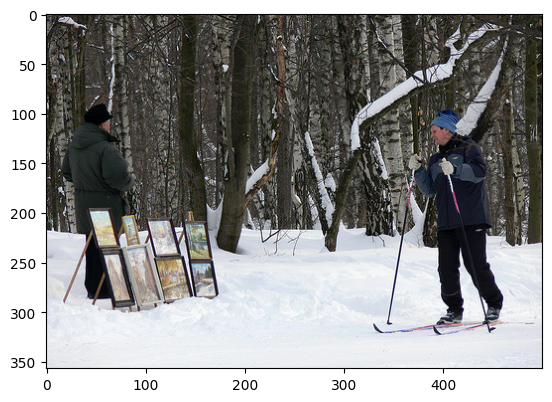

In [30]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs play with each other on the street endseq


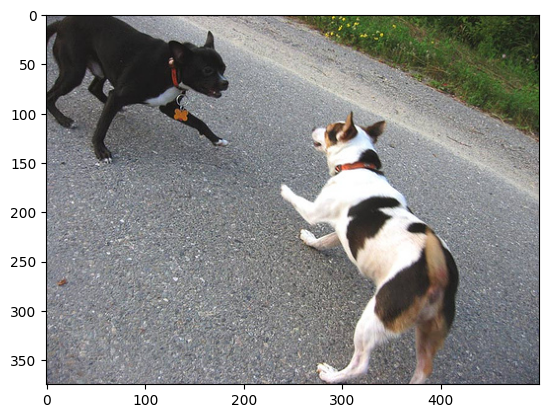

In [31]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq child playing on rope net endseq
startseq little girl climbing on red roping endseq
startseq little girl in pink climbs rope bridge at the park endseq
startseq small child grips onto the red ropes at the playground endseq
startseq the small child climbs on red ropes on playground endseq
--------------------Predicted--------------------
startseq child grips onto the ropes endseq


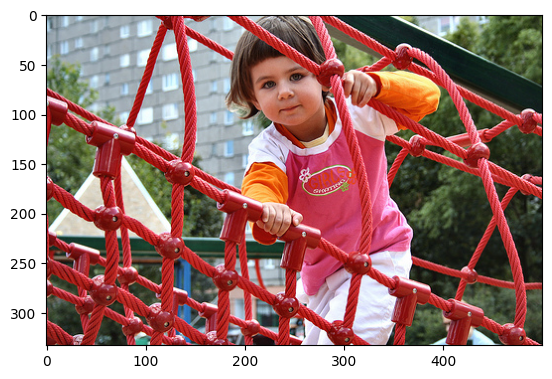

In [32]:
generate_caption("1007320043_627395c3d8.jpg")

---------------------Actual---------------------
startseq black dog and brown dog are jumping up to catch red toy endseq
startseq black dog and brown dog play with red toy on courtyard endseq
startseq brown and black lab are outside and the black lab is catching toy in its mouth endseq
startseq black dog snaps at red and black object as brown dog lunges endseq
startseq the chocolate lab jumps too late to get the toy as the black lab captures it in the driveway endseq
--------------------Predicted--------------------
startseq black dog snaps at the camera with stubby dog in red collar endseq


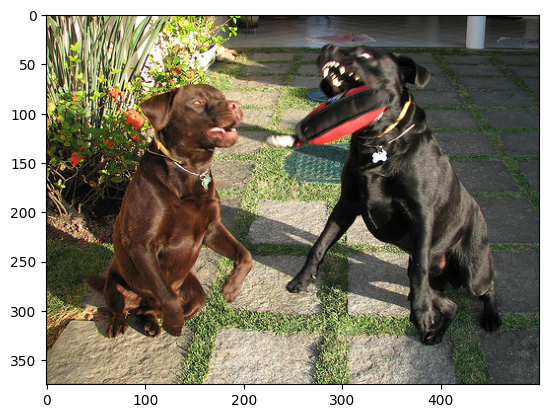

In [33]:
generate_caption("1030985833_b0902ea560.jpg")

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs play with each other on the street endseq


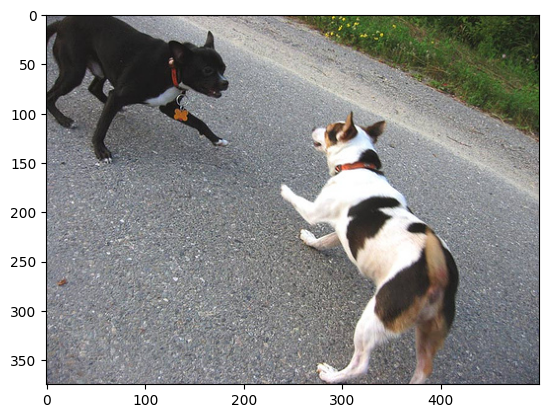

In [34]:
generate_caption("1001773457_577c3a7d70.jpg")